# 04 - Conditional VAE para duração de viagens com clima

Neste notebook treinamos um **Conditional Variational Autoencoder (CVAE)** para modelar a **distribuição do tempo de viagem** (`duration_min`) 
condicionado em:

- contexto temporal (`hour`, `weekday`, `is_peak_hour`)
- características da viagem (`distance_km`, `rideable_type`, `member_casual`)
- clima (`temp`, `precip`, `humidity`, etc., além de categorias como `conditions`, `preciptype`, `icon`)

O CVAE aprende uma distribuição latente `z` tal que podemos **gerar vários cenários de duração** para o mesmo contexto (clima+tempo+distância).
Depois comparamos com os baselines probabilísticos.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from tqdm import tqdm
import json
import os

plt.rcParams['figure.figsize'] = (6, 6)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

DATA_PATH = "data/processed/travel_features_rich.csv"
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)

print(df.head())

Using device: cpu
Dataset shape: (1679452, 29)
   duration_min  hour  weekday  distance_km  rideable_type member_casual  \
0      2.550000    17        2     1.044301  electric_bike        member   
1     13.734617    23        4     1.727745   classic_bike        member   
2     11.842950    19        2     1.807678  electric_bike        member   
3      4.060483    12        3     0.468681   classic_bike        member   
4     23.020733    10        5     0.468681   classic_bike        member   

   is_peak_hour  is_rainy  is_snowy  temp  ...  windspeed  winddir  \
0             1         0         0  11.3  ...       11.1    264.0   
1             0         0         0   8.3  ...       17.4    272.0   
2             1         0         0  10.5  ...        8.9    291.0   
3             0         0         0   2.5  ...       16.6    233.0   
4             1         0         0   4.1  ...       17.3    318.0   

   sealevelpressure  cloudcover  visibility solarradiation  solarenergy  \


In [9]:
# Diagnóstico: ver todas as colunas disponíveis
print("Colunas disponíveis no dataset:")
print(df.columns.tolist())
print(f"\nTotal de colunas: {len(df.columns)}")
print(f"\nTipos de dados:")
print(df.dtypes)

Colunas disponíveis no dataset:
['duration_min', 'hour', 'weekday', 'distance_km', 'rideable_type', 'member_casual', 'is_peak_hour', 'is_rainy', 'is_snowy', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'conditions', 'icon']

Total de colunas: 29

Tipos de dados:
duration_min        float64
hour                  int64
weekday               int64
distance_km         float64
rideable_type        object
member_casual        object
is_peak_hour          int64
is_rainy              int64
is_snowy              int64
temp                float64
feelslike           float64
dew                 float64
humidity            float64
precip              float64
precipprob          float64
preciptype           object
snow                float64
snowdepth           float64
windgust            float64
windspeed           flo

## 1. Preparação dos dados

Vamos:
- escolher as features numéricas e categóricas
- aplicar one-hot nas categóricas
- aplicar `log1p` + padronização em `duration_min`
- padronizar apenas as features numéricas


In [10]:
target_col = "duration_min"

numeric_cols = [
    "hour", "weekday",
    "distance_km",
    "is_peak_hour", "is_rainy", "is_snowy",
    "temp", "feelslike", "dew", "humidity",
    "precip", "precipprob", "snow", "snowdepth",
    "windgust", "windspeed", "winddir",
    "sealevelpressure", "cloudcover",
    "visibility", "solarradiation", "solarenergy",
    "uvindex"
]

cat_cols = ["rideable_type", "member_casual", "preciptype", "conditions", "icon"]

all_cols = [target_col] + numeric_cols + cat_cols
df_model = df[all_cols].copy()

# Verificar e tratar valores faltantes
print("Valores faltantes por coluna:")
missing = df_model.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("Nenhum valor faltante!")

# Preencher NaNs em colunas numéricas com mediana
for col in numeric_cols:
    if df_model[col].isnull().any():
        median_val = df_model[col].median()
        df_model[col].fillna(median_val, inplace=True)
        print(f"Preenchido {col} com mediana: {median_val}")

# Preencher NaNs em colunas categóricas com 'unknown'
for col in cat_cols:
    if df_model[col].isnull().any():
        df_model[col].fillna('unknown', inplace=True)
        print(f"Preenchido {col} com 'unknown'")

# Remover linhas onde target é NaN
before = len(df_model)
df_model = df_model.dropna(subset=[target_col])
after = len(df_model)
if before != after:
    print(f"Removidas {before - after} linhas com target NaN")

print(f"\nDataset após tratamento de NaNs: {df_model.shape}")

# Separar features numéricas e categóricas SEM processar ainda
X_num = df_model[numeric_cols].values.astype(np.float32)
X_cat = df_model[cat_cols].values  # manter como está para one-hot depois

y_raw = df_model[target_col].values.astype(np.float32)

# Transformação log no alvo (mais estável)
y_log = np.log1p(y_raw)

# ⚠️ IMPORTANTE: Split ANTES de qualquer normalização ou one-hot encoding
# Primeiro separamos test, depois quebramos o restante em train/val
X_num_temp, X_num_test, X_cat_temp, X_cat_test, y_temp, y_test = train_test_split(
    X_num, X_cat, y_log, test_size=0.2, random_state=42
)
X_num_train, X_num_val, X_cat_train, X_cat_val, y_train, y_val = train_test_split(
    X_num_temp, X_cat_temp, y_temp, test_size=0.2, random_state=42
)

print("Train size:", X_num_train.shape[0])
print("Val size:  ", X_num_val.shape[0])
print("Test size: ", X_num_test.shape[0])

# Opcional: limitar tamanho do treino/val para acelerar (amostragem)
MAX_TRAIN = 150_000
MAX_VAL   = 30_000

if X_num_train.shape[0] > MAX_TRAIN:
    idx = np.random.choice(X_num_train.shape[0], size=MAX_TRAIN, replace=False)
    X_num_train = X_num_train[idx]
    X_cat_train = X_cat_train[idx]
    y_train = y_train[idx]
    print("Subamostrando treino para", X_num_train.shape[0])

if X_num_val.shape[0] > MAX_VAL:
    idx = np.random.choice(X_num_val.shape[0], size=MAX_VAL, replace=False)
    X_num_val = X_num_val[idx]
    X_cat_val = X_cat_val[idx]
    y_val = y_val[idx]
    print("Subamostrando validação para", X_num_val.shape[0])

# ==== PASSO 1: Padronizar features NUMÉRICAS (apenas no train, depois aplicar no val/test) ====
num_scaler = StandardScaler()
X_num_train_scaled = num_scaler.fit_transform(X_num_train).astype(np.float32)
X_num_val_scaled   = num_scaler.transform(X_num_val).astype(np.float32)
X_num_test_scaled  = num_scaler.transform(X_num_test).astype(np.float32)

# ==== PASSO 2: One-hot encoding das categóricas (fit apenas no train) ====
# Criar DataFrames temporários para usar pd.get_dummies de forma consistente
df_cat_train = pd.DataFrame(X_cat_train, columns=cat_cols)
df_cat_val = pd.DataFrame(X_cat_val, columns=cat_cols)
df_cat_test = pd.DataFrame(X_cat_test, columns=cat_cols)

# One-hot encoding (importante: usar mesmas categorias em todos os conjuntos)
df_cat_train_encoded = pd.get_dummies(df_cat_train, drop_first=False)
df_cat_val_encoded = pd.get_dummies(df_cat_val, drop_first=False)
df_cat_test_encoded = pd.get_dummies(df_cat_test, drop_first=False)

# Garantir que val e test tenham as mesmas colunas que train
for col in df_cat_train_encoded.columns:
    if col not in df_cat_val_encoded.columns:
        df_cat_val_encoded[col] = 0
    if col not in df_cat_test_encoded.columns:
        df_cat_test_encoded[col] = 0

# Remover colunas extras que possam existir em val/test mas não em train
df_cat_val_encoded = df_cat_val_encoded[df_cat_train_encoded.columns]
df_cat_test_encoded = df_cat_test_encoded[df_cat_train_encoded.columns]

X_cat_train_encoded = df_cat_train_encoded.values.astype(np.float32)
X_cat_val_encoded = df_cat_val_encoded.values.astype(np.float32)
X_cat_test_encoded = df_cat_test_encoded.values.astype(np.float32)

# ==== PASSO 3: Concatenar features numéricas (escaladas) + categóricas (one-hot) ====
X_train_proc = np.concatenate([X_num_train_scaled, X_cat_train_encoded], axis=1)
X_val_proc   = np.concatenate([X_num_val_scaled, X_cat_val_encoded], axis=1)
X_test_proc  = np.concatenate([X_num_test_scaled, X_cat_test_encoded], axis=1)

print(f"\n✅ Features processadas:")
print(f"Dimensão numérica: {X_num_train_scaled.shape[1]}")
print(f"Dimensão categórica (one-hot): {X_cat_train_encoded.shape[1]}")
print(f"Dimensão final total: {X_train_proc.shape[1]}")

# ==== PASSO 4: Padronizar y_log (fit apenas no train) ====
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten().astype(np.float32)
y_val_scaled   = y_scaler.transform(y_val.reshape(-1, 1)).flatten().astype(np.float32)
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1)).flatten().astype(np.float32)

print("\n✅ Processamento concluído:")
print(f"Dimensão final de X: {X_train_proc.shape[1]}")
print(f"Dtype de X_train_proc: {X_train_proc.dtype}")
print(f"Dtype de y_train_scaled: {y_train_scaled.dtype}")

# ==== DIAGNÓSTICO: Verificar distribuição dos targets ====
print(f"\n{'='*80}")
print("📊 DIAGNÓSTICO - Distribuição do target (duration_min em log)")
print(f"{'='*80}")
print(f"\nTRAIN (n={len(y_train)}):")
print(f"   Média: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"   Min: {y_train.min():.4f}, Max: {y_train.max():.4f}")
print(f"\nVAL (n={len(y_val)}):")
print(f"   Média: {y_val.mean():.4f}, Std: {y_val.std():.4f}")
print(f"   Min: {y_val.min():.4f}, Max: {y_val.max():.4f}")
print(f"\nTEST (n={len(y_test)}):")
print(f"   Média: {y_test.mean():.4f}, Std: {y_test.std():.4f}")
print(f"   Min: {y_test.min():.4f}, Max: {y_test.max():.4f}")

# Converter para minutos para melhor interpretação
y_train_min = np.expm1(y_train)
y_val_min = np.expm1(y_val)
y_test_min = np.expm1(y_test)

print(f"\n📊 Distribuição do target (duration_min em MINUTOS)")
print(f"{'='*80}")
print(f"\nTRAIN:")
print(f"   Média: {y_train_min.mean():.2f} min, Mediana: {np.median(y_train_min):.2f} min")
print(f"   Min: {y_train_min.min():.2f} min, Max: {y_train_min.max():.2f} min")
print(f"\nVAL:")
print(f"   Média: {y_val_min.mean():.2f} min, Mediana: {np.median(y_val_min):.2f} min")
print(f"   Min: {y_val_min.min():.2f} min, Max: {y_val_min.max():.2f} min")
print(f"\nTEST:")
print(f"   Média: {y_test_min.mean():.2f} min, Mediana: {np.median(y_test_min):.2f} min")
print(f"   Min: {y_test_min.min():.2f} min, Max: {y_test_min.max():.2f} min")
print(f"{'='*80}\n")

Valores faltantes por coluna:
Nenhum valor faltante!
Nenhum valor faltante!

Dataset após tratamento de NaNs: (1679452, 29)

Dataset após tratamento de NaNs: (1679452, 29)
Train size: 1074848
Val size:   268713
Test size:  335891
Subamostrando treino para 150000
Subamostrando validação para 30000
Train size: 1074848
Val size:   268713
Test size:  335891
Subamostrando treino para 150000
Subamostrando validação para 30000

✅ Features processadas:
Dimensão numérica: 23
Dimensão categórica (one-hot): 22
Dimensão final total: 45

✅ Processamento concluído:
Dimensão final de X: 45
Dtype de X_train_proc: float32
Dtype de y_train_scaled: float32

📊 DIAGNÓSTICO - Distribuição do target (duration_min em log)

TRAIN (n=150000):
   Média: 2.2392, Std: 0.6764
   Min: 0.6942, Max: 4.1108

VAL (n=30000):
   Média: 2.2403, Std: 0.6743
   Min: 0.6953, Max: 4.1098

TEST (n=335891):
   Média: 2.2397, Std: 0.6774
   Min: 0.6933, Max: 4.1108

📊 Distribuição do target (duration_min em MINUTOS)

TRAIN:
   Mé

## 2. Dataset e DataLoaders

O CVAE aqui terá:

- **entrada do encoder**: concatenação de `[y_scaled, cond]`
- **entrada do decoder**: concatenação de `[z, cond]`

onde `cond` são todas as features de contexto (tempo, clima, distância, etc.).


In [11]:
class TravelCVAEWrapperDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float().unsqueeze(1)  # (N,1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 512

train_dataset = TravelCVAEWrapperDataset(X_train_proc, y_train_scaled)
val_dataset   = TravelCVAEWrapperDataset(X_val_proc, y_val_scaled)
test_dataset  = TravelCVAEWrapperDataset(X_test_proc, y_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

cond_dim = X_train_proc.shape[1]
print("cond_dim:", cond_dim)


cond_dim: 45


## 3. Definição do CVAE

O modelo segue a formulação clássica:

- Encoder: \( q_\phi(z \mid y, c) \)
- Decoder: \( p_\theta(y \mid z, c) \)

Perdemos:
\[ \mathcal{L} = \mathrm{MSE}(y, \hat{y}) + \beta\,\mathrm{KL}(q_\phi(z \mid y, c) \Vert \mathcal{N}(0, I)) \]
onde treinamos no espaço de `y_scaled` (padronizado).


In [12]:
class CVAE(nn.Module):
    def __init__(self, cond_dim, latent_dim=8, hidden_dim=128, beta=1.0):
        super().__init__()
        self.cond_dim = cond_dim
        self.latent_dim = latent_dim
        self.beta = beta

        # Encoder: input = y (1) + cond_dim
        enc_input_dim = cond_dim + 1
        self.encoder = nn.Sequential(
            nn.Linear(enc_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder: input = z (latent_dim) + cond_dim
        dec_input_dim = latent_dim + cond_dim
        self.decoder = nn.Sequential(
            nn.Linear(dec_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # saída: y_hat_scaled
        )

    def encode(self, y, cond):
        x = torch.cat([y, cond], dim=1)  # (B, 1+cond_dim)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, cond):
        x = torch.cat([z, cond], dim=1)
        y_hat = self.decoder(x)
        return y_hat

    def forward(self, cond, y):
        mu, logvar = self.encode(y, cond)
        z = self.reparameterize(mu, logvar)
        y_hat = self.decode(z, cond)
        return y_hat, mu, logvar

    def loss_fn(self, y_hat, y, mu, logvar):
        # Reconstrução (MSE em y_scaled)
        recon_loss = nn.functional.mse_loss(y_hat, y, reduction="mean")
        # KL divergence
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + self.beta * kl, recon_loss, kl


In [6]:
def train_one_model(cond_dim, latent_dim, hidden_dim, beta=1.0,
                    max_epochs=50, patience=10, lr=1e-3):

    model = CVAE(cond_dim, latent_dim=latent_dim, hidden_dim=hidden_dim, beta=beta).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    best_val_loss = float("inf")
    best_state = None
    epochs_no_improve = 0
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_recon': [], 'val_recon': [],
        'train_kl': [], 'val_kl': []
    }

    epoch_pbar = tqdm(range(1, max_epochs+1), desc=f"[L={latent_dim},H={hidden_dim}]")
    for epoch in epoch_pbar:
        # === Training ===
        model.train()
        train_losses, train_recons, train_kls = [], [], []
        
        for cond_batch, y_batch in train_loader:
            cond_batch = cond_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            optimizer.zero_grad()
            y_hat, mu, logvar = model(cond_batch, y_batch)
            loss, recon_loss, kl = model.loss_fn(y_hat, y_batch, mu, logvar)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_losses.append(loss.item())
            train_recons.append(recon_loss.item())
            train_kls.append(kl.item())

        # === Validation ===
        model.eval()
        val_losses, val_recons, val_kls = [], [], []
        
        with torch.no_grad():
            for cond_batch, y_batch in val_loader:
                cond_batch = cond_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                y_hat, mu, logvar = model(cond_batch, y_batch)
                loss, recon_loss, kl = model.loss_fn(y_hat, y_batch, mu, logvar)
                val_losses.append(loss.item())
                val_recons.append(recon_loss.item())
                val_kls.append(kl.item())

        train_loss_mean = np.mean(train_losses)
        val_loss_mean = np.mean(val_losses)
        train_recon_mean = np.mean(train_recons)
        val_recon_mean = np.mean(val_recons)
        train_kl_mean = np.mean(train_kls)
        val_kl_mean = np.mean(val_kls)
        
        # Armazenar histórico
        history['train_loss'].append(train_loss_mean)
        history['val_loss'].append(val_loss_mean)
        history['train_recon'].append(train_recon_mean)
        history['val_recon'].append(val_recon_mean)
        history['train_kl'].append(train_kl_mean)
        history['val_kl'].append(val_kl_mean)
        
        # Atualizar learning rate
        scheduler.step(val_loss_mean)
        
        # Atualizar progress bar
        epoch_pbar.set_postfix({
            'train': f'{train_loss_mean:.4f}',
            'val': f'{val_loss_mean:.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })

        # Print detalhado a cada 5 épocas
        if epoch % 5 == 0 or epoch == 1:
            print(f"\nEpoch {epoch:02d} | "
                  f"train_loss={train_loss_mean:.4f} (r={train_recon_mean:.4f}, kl={train_kl_mean:.4f}) | "
                  f"val_loss={val_loss_mean:.4f} (r={val_recon_mean:.4f}, kl={val_kl_mean:.4f})")

        # Early stopping
        if val_loss_mean < best_val_loss - 1e-5:
            best_val_loss = val_loss_mean
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\n⚠️ Early stopping após {epoch} épocas!")
                break

    # Carregar melhor estado
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_loss, history

In [7]:
# ===== Grid Search Expandido =====

configs = [
    # Modelos muito pequenos (baseline)
    {"latent_dim": 2,  "hidden_dim": 16,  "beta": 0.01, "lr": 1e-3},
    {"latent_dim": 2,  "hidden_dim": 32,  "beta": 0.05, "lr": 1e-3},
    {"latent_dim": 2,  "hidden_dim": 32,  "beta": 0.1,  "lr": 1e-3},
    
    # Modelos pequenos - variando beta
    {"latent_dim": 4,  "hidden_dim": 32,  "beta": 0.05, "lr": 1e-3},
    {"latent_dim": 4,  "hidden_dim": 64,  "beta": 0.01, "lr": 1e-3},
    {"latent_dim": 4,  "hidden_dim": 64,  "beta": 0.1,  "lr": 1e-3},
    {"latent_dim": 4,  "hidden_dim": 64,  "beta": 0.5,  "lr": 1e-3},
    
    # Modelos médios - latent_dim=8, variando hidden e beta
    {"latent_dim": 8,  "hidden_dim": 64,  "beta": 0.01, "lr": 1e-3},
    {"latent_dim": 8,  "hidden_dim": 64,  "beta": 0.1,  "lr": 1e-3},
    {"latent_dim": 8,  "hidden_dim": 64,  "beta": 0.5,  "lr": 1e-3},
    {"latent_dim": 8,  "hidden_dim": 128, "beta": 0.01, "lr": 1e-3},
    {"latent_dim": 8,  "hidden_dim": 128, "beta": 0.05, "lr": 1e-3},
    {"latent_dim": 8,  "hidden_dim": 128, "beta": 0.1,  "lr": 1e-3},
    {"latent_dim": 8,  "hidden_dim": 128, "beta": 0.5,  "lr": 1e-3},
    {"latent_dim": 8,  "hidden_dim": 128, "beta": 1.0,  "lr": 1e-3},
    {"latent_dim": 8,  "hidden_dim": 256, "beta": 0.1,  "lr": 1e-3},
    {"latent_dim": 8,  "hidden_dim": 256, "beta": 0.5,  "lr": 5e-4},
    
    # Modelos médio-grandes - latent_dim=12
    {"latent_dim": 12, "hidden_dim": 128, "beta": 0.1,  "lr": 1e-3},
    {"latent_dim": 12, "hidden_dim": 128, "beta": 0.5,  "lr": 5e-4},
    {"latent_dim": 12, "hidden_dim": 256, "beta": 0.5,  "lr": 5e-4},
    
    # Modelos maiores - latent_dim=16, variando hidden e beta
    {"latent_dim": 16, "hidden_dim": 128, "beta": 0.1,  "lr": 5e-4},
    {"latent_dim": 16, "hidden_dim": 128, "beta": 0.5,  "lr": 5e-4},
    {"latent_dim": 16, "hidden_dim": 128, "beta": 1.0,  "lr": 5e-4},
    {"latent_dim": 16, "hidden_dim": 256, "beta": 0.5,  "lr": 5e-4},
    {"latent_dim": 16, "hidden_dim": 256, "beta": 1.0,  "lr": 5e-4},
    {"latent_dim": 16, "hidden_dim": 256, "beta": 1.0,  "lr": 1e-4},
    
    # Modelos muito grandes - latent_dim=24 e 32
    {"latent_dim": 24, "hidden_dim": 256, "beta": 0.5,  "lr": 5e-4},
    {"latent_dim": 24, "hidden_dim": 256, "beta": 1.0,  "lr": 5e-4},
    {"latent_dim": 32, "hidden_dim": 256, "beta": 1.0,  "lr": 5e-4},
    {"latent_dim": 32, "hidden_dim": 512, "beta": 1.0,  "lr": 1e-4},
]

# Criar diretório para salvar modelos
os.makedirs("models", exist_ok=True)

results = []
best_config = None
best_loss = float("inf")
best_model = None
best_history = None
best_model_path = None

print(f"🔍 Iniciando Grid Search com {len(configs)} configurações\n")
print(f"💾 Todos os modelos serão salvos em: models/\n")
print("="*80)

for i, cfg in enumerate(tqdm(configs, desc="Grid Search Progress")):
    print(f"\n{'='*80}")
    print(f"📊 Config {i+1}/{len(configs)}: {cfg}")
    print(f"{'='*80}\n")
    
    try:
        model, val_loss, history = train_one_model(
            cond_dim=cond_dim,
            latent_dim=cfg["latent_dim"],
            hidden_dim=cfg["hidden_dim"],
            beta=cfg["beta"],
            max_epochs=50,
            patience=10,
            lr=cfg["lr"]
        )
        
        # Criar nome do arquivo baseado nos hiperparâmetros
        model_filename = f"cvae_L{cfg['latent_dim']}_H{cfg['hidden_dim']}_B{cfg['beta']:.3f}_LR{cfg['lr']:.0e}.pt"
        model_path = os.path.join("models", model_filename)
        
        # Salvar modelo com metadados
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': cfg,
            'val_loss': val_loss,
            'cond_dim': cond_dim,
            'history': history,
            'final_train_loss': history['train_loss'][-1],
            'best_epoch': len(history['train_loss'])
        }, model_path)
        
        result = {
            'config': cfg,
            'val_loss': val_loss,
            'final_train_loss': history['train_loss'][-1],
            'best_epoch': len(history['train_loss']),
            'model_path': model_path
        }
        results.append(result)
        
        print(f"\n✅ Config {i+1} completa:")
        print(f"   Val Loss: {val_loss:.4f}")
        print(f"   Épocas treinadas: {len(history['train_loss'])}")
        print(f"   💾 Salvo em: {model_path}")
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_config = cfg
            best_model = model
            best_history = history
            best_model_path = model_path
            print(f"   🏆 NOVO MELHOR MODELO!")
            
    except Exception as e:
        print(f"\n❌ Erro na config {i+1}: {e}")
        results.append({
            'config': cfg,
            'val_loss': float('inf'),
            'error': str(e)
        })

print(f"\n{'='*80}")
print("📈 RESUMO DO GRID SEARCH")
print(f"{'='*80}\n")

# Ordenar resultados por val_loss
results_sorted = sorted(results, key=lambda x: x.get('val_loss', float('inf')))

print("Top 10 Melhores Configurações:\n")
for i, r in enumerate(results_sorted[:10], 1):
    if 'error' not in r:
        print(f"{i}. Val Loss: {r['val_loss']:.4f} | Config: {r['config']}")
    else:
        print(f"{i}. ERRO: {r['config']}")

print(f"\n{'='*80}")
print(f"🏆 MELHOR CONFIGURAÇÃO:")
print(f"{'='*80}")
if best_config is not None:
    print(f"Config: {best_config}")
    print(f"Val Loss: {best_loss:.4f}")
    print(f"Épocas: {len(best_history['train_loss'])}")
    print(f"💾 Modelo salvo em: {best_model_path}")
    
    # Salvar resumo de todos os resultados em JSON
    summary_path = "models/grid_search_summary.json"
    with open(summary_path, 'w') as f:
        json.dump({
            'best_config': best_config,
            'best_val_loss': best_loss,
            'best_model_path': best_model_path,
            'all_results': [
                {k: v for k, v in r.items() if k != 'error'} 
                for r in results if 'error' not in r
            ]
        }, f, indent=2)
    print(f"📋 Resumo salvo em: {summary_path}")
else:
    print("Nenhuma configuração concluída com sucesso.")
print(f"{'='*80}\n")

🔍 Iniciando Grid Search com 30 configurações

💾 Todos os modelos serão salvos em: models/



Grid Search Progress:   0%|          | 0/30 [00:00<?, ?it/s]


📊 Config 1/30: {'latent_dim': 2, 'hidden_dim': 16, 'beta': 0.01, 'lr': 0.001}



[L=2,H=16]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.3047 (r=0.2922, kl=1.2481) | val_loss=0.0231 (r=0.0077, kl=1.5375)


[L=2,H=16]:   2%|▏         | 1/50 [00:04<01:47,  2.20s/it, train=0.0195, val=0.0179, lr=1.00e-03]


Epoch 05 | train_loss=0.0164 (r=0.0030, kl=1.3394) | val_loss=0.0162 (r=0.0029, kl=1.3310)


[L=2,H=16]:  10%|█         | 5/50 [00:11<01:18,  1.74s/it, train=0.0162, val=0.0163, lr=1.00e-03]


Epoch 10 | train_loss=0.0160 (r=0.0029, kl=1.3104) | val_loss=0.0162 (r=0.0030, kl=1.3121)


[L=2,H=16]:  20%|██        | 10/50 [00:18<01:05,  1.64s/it, train=0.0159, val=0.0158, lr=1.00e-03]


Epoch 15 | train_loss=0.0158 (r=0.0028, kl=1.2972) | val_loss=0.0158 (r=0.0027, kl=1.3066)


[L=2,H=16]:  30%|███       | 15/50 [00:24<00:45,  1.30s/it, train=0.0158, val=0.0157, lr=1.00e-03]


Epoch 20 | train_loss=0.0157 (r=0.0028, kl=1.2878) | val_loss=0.0157 (r=0.0029, kl=1.2813)


[L=2,H=16]:  40%|████      | 20/50 [00:35<00:58,  1.96s/it, train=0.0156, val=0.0155, lr=5.00e-04]


Epoch 25 | train_loss=0.0155 (r=0.0027, kl=1.2828) | val_loss=0.0154 (r=0.0026, kl=1.2851)


[L=2,H=16]:  50%|█████     | 25/50 [00:47<00:58,  2.33s/it, train=0.0155, val=0.0156, lr=5.00e-04]


Epoch 30 | train_loss=0.0155 (r=0.0027, kl=1.2745) | val_loss=0.0155 (r=0.0027, kl=1.2765)


[L=2,H=16]:  60%|██████    | 30/50 [00:56<00:34,  1.73s/it, train=0.0155, val=0.0155, lr=5.00e-04]


Epoch 35 | train_loss=0.0154 (r=0.0027, kl=1.2705) | val_loss=0.0154 (r=0.0027, kl=1.2634)


[L=2,H=16]:  70%|███████   | 35/50 [01:07<00:32,  2.17s/it, train=0.0153, val=0.0154, lr=2.50e-04]


Epoch 40 | train_loss=0.0153 (r=0.0027, kl=1.2676) | val_loss=0.0154 (r=0.0027, kl=1.2637)


[L=2,H=16]:  80%|████████  | 40/50 [01:19<00:22,  2.26s/it, train=0.0153, val=0.0153, lr=2.50e-04]


Epoch 45 | train_loss=0.0153 (r=0.0026, kl=1.2633) | val_loss=0.0154 (r=0.0027, kl=1.2632)


Grid Search Progress:   3%|▎         | 1/30 [01:36<46:32, 96.30s/it]


Epoch 50 | train_loss=0.0153 (r=0.0026, kl=1.2634) | val_loss=0.0152 (r=0.0026, kl=1.2617)

✅ Config 1 completa:
   Val Loss: 0.0153
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L2_H16_B0.010_LR1e-03.pt
   🏆 NOVO MELHOR MODELO!

📊 Config 2/30: {'latent_dim': 2, 'hidden_dim': 32, 'beta': 0.05, 'lr': 0.001}



[L=2,H=32]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.2552 (r=0.2192, kl=0.7208) | val_loss=0.0643 (r=0.0192, kl=0.9026)


[L=2,H=32]:   2%|▏         | 1/50 [00:03<02:02,  2.49s/it, train=0.0610, val=0.0596, lr=1.00e-03]


Epoch 05 | train_loss=0.0559 (r=0.0149, kl=0.8196) | val_loss=0.0572 (r=0.0168, kl=0.8071)


[L=2,H=32]:  10%|█         | 5/50 [00:12<01:35,  2.13s/it, train=0.0545, val=0.0542, lr=1.00e-03]


Epoch 10 | train_loss=0.0509 (r=0.0145, kl=0.7264) | val_loss=0.0506 (r=0.0149, kl=0.7137)


[L=2,H=32]:  20%|██        | 10/50 [00:23<01:33,  2.33s/it, train=0.0503, val=0.0500, lr=1.00e-03]


Epoch 15 | train_loss=0.0491 (r=0.0142, kl=0.6995) | val_loss=0.0494 (r=0.0143, kl=0.7013)


[L=2,H=32]:  30%|███       | 15/50 [00:33<01:19,  2.28s/it, train=0.0490, val=0.0492, lr=1.00e-03]


Epoch 20 | train_loss=0.0484 (r=0.0139, kl=0.6889) | val_loss=0.0478 (r=0.0140, kl=0.6747)


[L=2,H=32]:  40%|████      | 20/50 [00:43<00:57,  1.92s/it, train=0.0482, val=0.0477, lr=1.00e-03]


Epoch 25 | train_loss=0.0480 (r=0.0138, kl=0.6856) | val_loss=0.0480 (r=0.0138, kl=0.6827)


[L=2,H=32]:  50%|█████     | 25/50 [00:53<00:48,  1.92s/it, train=0.0480, val=0.0475, lr=1.00e-03]


Epoch 30 | train_loss=0.0478 (r=0.0138, kl=0.6818) | val_loss=0.0472 (r=0.0130, kl=0.6846)


[L=2,H=32]:  60%|██████    | 30/50 [01:05<00:41,  2.08s/it, train=0.0478, val=0.0490, lr=1.00e-03]


Epoch 35 | train_loss=0.0475 (r=0.0135, kl=0.6797) | val_loss=0.0473 (r=0.0141, kl=0.6643)


[L=2,H=32]:  70%|███████   | 35/50 [01:16<00:36,  2.42s/it, train=0.0473, val=0.0471, lr=1.00e-03]


Epoch 40 | train_loss=0.0475 (r=0.0135, kl=0.6785) | val_loss=0.0470 (r=0.0136, kl=0.6695)


[L=2,H=32]:  80%|████████  | 40/50 [01:25<00:17,  1.78s/it, train=0.0473, val=0.0484, lr=1.00e-03]


Epoch 45 | train_loss=0.0469 (r=0.0131, kl=0.6775) | val_loss=0.0467 (r=0.0132, kl=0.6715)


Grid Search Progress:   7%|▋         | 2/30 [03:19<46:52, 100.45s/it]


Epoch 50 | train_loss=0.0466 (r=0.0128, kl=0.6760) | val_loss=0.0466 (r=0.0133, kl=0.6663)

✅ Config 2 completa:
   Val Loss: 0.0466
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L2_H32_B0.050_LR1e-03.pt

📊 Config 3/30: {'latent_dim': 2, 'hidden_dim': 32, 'beta': 0.1, 'lr': 0.001}



[L=2,H=32]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.3022 (r=0.2478, kl=0.5438) | val_loss=0.1016 (r=0.0312, kl=0.7038)


[L=2,H=32]:   2%|▏         | 1/50 [00:04<02:03,  2.52s/it, train=0.0972, val=0.0937, lr=1.00e-03]


Epoch 05 | train_loss=0.0839 (r=0.0282, kl=0.5569) | val_loss=0.0825 (r=0.0274, kl=0.5514)


[L=2,H=32]:  10%|█         | 5/50 [00:11<01:24,  1.89s/it, train=0.0821, val=0.0817, lr=1.00e-03]


Epoch 10 | train_loss=0.0794 (r=0.0271, kl=0.5230) | val_loss=0.0786 (r=0.0262, kl=0.5244)


[L=2,H=32]:  20%|██        | 10/50 [00:23<01:19,  1.99s/it, train=0.0789, val=0.0783, lr=1.00e-03]


Epoch 15 | train_loss=0.0784 (r=0.0266, kl=0.5182) | val_loss=0.0786 (r=0.0268, kl=0.5170)


[L=2,H=32]:  30%|███       | 15/50 [00:33<01:07,  1.93s/it, train=0.0779, val=0.0773, lr=1.00e-03]


Epoch 20 | train_loss=0.0776 (r=0.0261, kl=0.5147) | val_loss=0.0773 (r=0.0258, kl=0.5149)


[L=2,H=32]:  40%|████      | 20/50 [00:42<01:00,  2.00s/it, train=0.0774, val=0.0773, lr=1.00e-03]


Epoch 25 | train_loss=0.0765 (r=0.0254, kl=0.5105) | val_loss=0.0760 (r=0.0257, kl=0.5023)


[L=2,H=32]:  50%|█████     | 25/50 [00:51<00:39,  1.60s/it, train=0.0766, val=0.0759, lr=5.00e-04]


Epoch 30 | train_loss=0.0765 (r=0.0254, kl=0.5114) | val_loss=0.0762 (r=0.0256, kl=0.5059)


[L=2,H=32]:  60%|██████    | 30/50 [01:04<00:46,  2.34s/it, train=0.0759, val=0.0761, lr=2.50e-04]


Epoch 35 | train_loss=0.0758 (r=0.0249, kl=0.5088) | val_loss=0.0758 (r=0.0254, kl=0.5043)


[L=2,H=32]:  70%|███████   | 35/50 [01:16<00:36,  2.45s/it, train=0.0760, val=0.0756, lr=1.25e-04]


Epoch 40 | train_loss=0.0756 (r=0.0249, kl=0.5076) | val_loss=0.0759 (r=0.0257, kl=0.5015)


[L=2,H=32]:  80%|████████  | 40/50 [01:26<00:22,  2.29s/it, train=0.0756, val=0.0754, lr=6.25e-05]


Epoch 45 | train_loss=0.0757 (r=0.0247, kl=0.5100) | val_loss=0.0756 (r=0.0253, kl=0.5037)


Grid Search Progress:  10%|█         | 3/30 [04:56<44:23, 98.63s/it] 


⚠️ Early stopping após 47 épocas!

✅ Config 3 completa:
   Val Loss: 0.0752
   Épocas treinadas: 47
   💾 Salvo em: models/cvae_L2_H32_B0.100_LR1e-03.pt

📊 Config 4/30: {'latent_dim': 4, 'hidden_dim': 32, 'beta': 0.05, 'lr': 0.001}



[L=4,H=32]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.2559 (r=0.2250, kl=0.6193) | val_loss=0.0415 (r=0.0117, kl=0.5970)


[L=4,H=32]:   2%|▏         | 1/50 [00:02<01:02,  1.28s/it, train=0.0375, val=0.0356, lr=1.00e-03]


Epoch 05 | train_loss=0.0337 (r=0.0074, kl=0.5249) | val_loss=0.0335 (r=0.0076, kl=0.5181)



Epoch 10 | train_loss=0.0321 (r=0.0073, kl=0.4949) | val_loss=0.0319 (r=0.0075, kl=0.4880)


[L=4,H=32]:  20%|██        | 10/50 [00:17<01:01,  1.53s/it, train=0.0317, val=0.0317, lr=1.00e-03]


Epoch 15 | train_loss=0.0306 (r=0.0073, kl=0.4668) | val_loss=0.0307 (r=0.0075, kl=0.4639)


[L=4,H=32]:  30%|███       | 15/50 [00:24<00:44,  1.26s/it, train=0.0304, val=0.0307, lr=1.00e-03]


Epoch 20 | train_loss=0.0297 (r=0.0072, kl=0.4505) | val_loss=0.0297 (r=0.0073, kl=0.4476)


[L=4,H=32]:  40%|████      | 20/50 [00:34<00:57,  1.93s/it, train=0.0295, val=0.0293, lr=1.00e-03]


Epoch 25 | train_loss=0.0292 (r=0.0071, kl=0.4418) | val_loss=0.0291 (r=0.0070, kl=0.4411)


[L=4,H=32]:  50%|█████     | 25/50 [00:46<01:01,  2.45s/it, train=0.0291, val=0.0295, lr=1.00e-03]


Epoch 30 | train_loss=0.0289 (r=0.0071, kl=0.4366) | val_loss=0.0286 (r=0.0069, kl=0.4346)


[L=4,H=32]:  60%|██████    | 30/50 [00:58<00:46,  2.33s/it, train=0.0289, val=0.0288, lr=1.00e-03]


Epoch 35 | train_loss=0.0287 (r=0.0070, kl=0.4336) | val_loss=0.0284 (r=0.0067, kl=0.4340)


[L=4,H=32]:  70%|███████   | 35/50 [01:09<00:32,  2.18s/it, train=0.0288, val=0.0291, lr=1.00e-03]


Epoch 40 | train_loss=0.0282 (r=0.0067, kl=0.4307) | val_loss=0.0281 (r=0.0067, kl=0.4278)


[L=4,H=32]:  80%|████████  | 40/50 [01:17<00:16,  1.66s/it, train=0.0282, val=0.0283, lr=5.00e-04]


Epoch 45 | train_loss=0.0281 (r=0.0066, kl=0.4304) | val_loss=0.0280 (r=0.0065, kl=0.4306)


Grid Search Progress:  13%|█▎        | 4/30 [06:31<42:13, 97.44s/it]


Epoch 50 | train_loss=0.0280 (r=0.0065, kl=0.4293) | val_loss=0.0279 (r=0.0068, kl=0.4223)

✅ Config 4 completa:
   Val Loss: 0.0279
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L4_H32_B0.050_LR1e-03.pt

📊 Config 5/30: {'latent_dim': 4, 'hidden_dim': 64, 'beta': 0.01, 'lr': 0.001}



[L=4,H=64]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1507 (r=0.1377, kl=1.2978) | val_loss=0.0188 (r=0.0056, kl=1.3177)


[L=4,H=64]:   2%|▏         | 1/50 [00:05<02:07,  2.59s/it, train=0.0140, val=0.0117, lr=1.00e-03]


Epoch 05 | train_loss=0.0098 (r=0.0022, kl=0.7562) | val_loss=0.0096 (r=0.0020, kl=0.7544)


[L=4,H=64]:  10%|█         | 5/50 [00:13<01:46,  2.37s/it, train=0.0096, val=0.0093, lr=1.00e-03]


Epoch 10 | train_loss=0.0091 (r=0.0017, kl=0.7362) | val_loss=0.0092 (r=0.0018, kl=0.7400)


[L=4,H=64]:  20%|██        | 10/50 [00:23<01:22,  2.06s/it, train=0.0091, val=0.0092, lr=1.00e-03]


Epoch 15 | train_loss=0.0090 (r=0.0017, kl=0.7240) | val_loss=0.0089 (r=0.0017, kl=0.7221)


[L=4,H=64]:  30%|███       | 15/50 [00:31<00:54,  1.55s/it, train=0.0088, val=0.0087, lr=1.00e-03]


Epoch 20 | train_loss=0.0087 (r=0.0016, kl=0.7104) | val_loss=0.0086 (r=0.0016, kl=0.7089)


[L=4,H=64]:  40%|████      | 20/50 [00:41<00:54,  1.83s/it, train=0.0087, val=0.0086, lr=1.00e-03]


Epoch 25 | train_loss=0.0086 (r=0.0016, kl=0.6965) | val_loss=0.0086 (r=0.0016, kl=0.6990)


[L=4,H=64]:  50%|█████     | 25/50 [00:50<00:47,  1.91s/it, train=0.0086, val=0.0086, lr=1.00e-03]


Epoch 30 | train_loss=0.0085 (r=0.0016, kl=0.6859) | val_loss=0.0084 (r=0.0016, kl=0.6849)


[L=4,H=64]:  60%|██████    | 30/50 [01:01<00:38,  1.92s/it, train=0.0085, val=0.0084, lr=1.00e-03]


Epoch 35 | train_loss=0.0083 (r=0.0016, kl=0.6738) | val_loss=0.0083 (r=0.0015, kl=0.6809)


[L=4,H=64]:  70%|███████   | 35/50 [01:12<00:37,  2.51s/it, train=0.0084, val=0.0087, lr=1.00e-03]


Epoch 40 | train_loss=0.0083 (r=0.0016, kl=0.6666) | val_loss=0.0082 (r=0.0015, kl=0.6684)


[L=4,H=64]:  80%|████████  | 40/50 [01:23<00:21,  2.13s/it, train=0.0082, val=0.0083, lr=1.00e-03]


Epoch 45 | train_loss=0.0082 (r=0.0016, kl=0.6590) | val_loss=0.0083 (r=0.0017, kl=0.6562)


Grid Search Progress:  17%|█▋        | 5/30 [08:16<41:45, 100.22s/it]


Epoch 50 | train_loss=0.0081 (r=0.0016, kl=0.6532) | val_loss=0.0081 (r=0.0016, kl=0.6547)

✅ Config 5 completa:
   Val Loss: 0.0080
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L4_H64_B0.010_LR1e-03.pt
   🏆 NOVO MELHOR MODELO!

📊 Config 6/30: {'latent_dim': 4, 'hidden_dim': 64, 'beta': 0.1, 'lr': 0.001}



[L=4,H=64]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.2065 (r=0.1548, kl=0.5166) | val_loss=0.0815 (r=0.0277, kl=0.5372)


[L=4,H=64]:   2%|▏         | 1/50 [00:03<01:04,  1.32s/it, train=0.0633, val=0.0582, lr=1.00e-03]


Epoch 05 | train_loss=0.0529 (r=0.0151, kl=0.3784) | val_loss=0.0525 (r=0.0154, kl=0.3709)


[L=4,H=64]:  10%|█         | 5/50 [00:11<01:31,  2.03s/it, train=0.0517, val=0.0512, lr=1.00e-03]


Epoch 10 | train_loss=0.0495 (r=0.0143, kl=0.3517) | val_loss=0.0494 (r=0.0145, kl=0.3490)


[L=4,H=64]:  20%|██        | 10/50 [00:22<01:21,  2.03s/it, train=0.0490, val=0.0494, lr=1.00e-03]


Epoch 15 | train_loss=0.0482 (r=0.0140, kl=0.3426) | val_loss=0.0488 (r=0.0150, kl=0.3382)


[L=4,H=64]:  30%|███       | 15/50 [00:35<01:26,  2.47s/it, train=0.0483, val=0.0481, lr=1.00e-03]


Epoch 20 | train_loss=0.0478 (r=0.0137, kl=0.3404) | val_loss=0.0484 (r=0.0139, kl=0.3445)


[L=4,H=64]:  40%|████      | 20/50 [00:47<01:08,  2.28s/it, train=0.0479, val=0.0475, lr=1.00e-03]


Epoch 25 | train_loss=0.0475 (r=0.0136, kl=0.3381) | val_loss=0.0472 (r=0.0130, kl=0.3420)


[L=4,H=64]:  50%|█████     | 25/50 [00:59<00:58,  2.36s/it, train=0.0476, val=0.0478, lr=1.00e-03]


Epoch 30 | train_loss=0.0474 (r=0.0137, kl=0.3373) | val_loss=0.0477 (r=0.0142, kl=0.3351)


[L=4,H=64]:  60%|██████    | 30/50 [01:11<00:47,  2.36s/it, train=0.0472, val=0.0469, lr=1.00e-03]


Epoch 35 | train_loss=0.0466 (r=0.0130, kl=0.3361) | val_loss=0.0466 (r=0.0126, kl=0.3392)


[L=4,H=64]:  70%|███████   | 35/50 [01:20<00:28,  1.88s/it, train=0.0468, val=0.0469, lr=5.00e-04]


Epoch 40 | train_loss=0.0467 (r=0.0130, kl=0.3375) | val_loss=0.0469 (r=0.0133, kl=0.3364)


[L=4,H=64]:  80%|████████  | 40/50 [01:33<00:24,  2.40s/it, train=0.0467, val=0.0468, lr=2.50e-04]


Epoch 45 | train_loss=0.0465 (r=0.0127, kl=0.3371) | val_loss=0.0462 (r=0.0131, kl=0.3310)


Grid Search Progress:  20%|██        | 6/30 [10:10<41:56, 104.87s/it]


Epoch 50 | train_loss=0.0464 (r=0.0128, kl=0.3362) | val_loss=0.0464 (r=0.0123, kl=0.3408)

✅ Config 6 completa:
   Val Loss: 0.0462
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L4_H64_B0.100_LR1e-03.pt

📊 Config 7/30: {'latent_dim': 4, 'hidden_dim': 64, 'beta': 0.5, 'lr': 0.001}



[L=4,H=64]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.3012 (r=0.2087, kl=0.1850) | val_loss=0.1691 (r=0.0796, kl=0.1789)


[L=4,H=64]:   2%|▏         | 1/50 [00:04<02:10,  2.67s/it, train=0.1562, val=0.1482, lr=1.00e-03]


Epoch 05 | train_loss=0.1411 (r=0.0635, kl=0.1554) | val_loss=0.1387 (r=0.0619, kl=0.1537)


[L=4,H=64]:  10%|█         | 5/50 [00:14<01:54,  2.54s/it, train=0.1405, val=0.1384, lr=1.00e-03]


Epoch 10 | train_loss=0.1379 (r=0.0622, kl=0.1513) | val_loss=0.1377 (r=0.0624, kl=0.1507)



Epoch 15 | train_loss=0.1364 (r=0.0614, kl=0.1501) | val_loss=0.1366 (r=0.0659, kl=0.1415)


[L=4,H=64]:  30%|███       | 15/50 [00:39<01:32,  2.65s/it, train=0.1345, val=0.1345, lr=5.00e-04]


Epoch 20 | train_loss=0.1344 (r=0.0598, kl=0.1491) | val_loss=0.1337 (r=0.0582, kl=0.1512)


[L=4,H=64]:  40%|████      | 20/50 [00:52<01:21,  2.71s/it, train=0.1343, val=0.1341, lr=5.00e-04]


Epoch 25 | train_loss=0.1339 (r=0.0595, kl=0.1487) | val_loss=0.1333 (r=0.0590, kl=0.1486)


Grid Search Progress:  23%|██▎       | 7/30 [11:17<35:21, 92.25s/it] 


⚠️ Early stopping após 28 épocas!

✅ Config 7 completa:
   Val Loss: 0.1327
   Épocas treinadas: 28
   💾 Salvo em: models/cvae_L4_H64_B0.500_LR1e-03.pt

📊 Config 8/30: {'latent_dim': 8, 'hidden_dim': 64, 'beta': 0.01, 'lr': 0.001}



[L=8,H=64]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1410 (r=0.1299, kl=1.1095) | val_loss=0.0165 (r=0.0053, kl=1.1117)


[L=8,H=64]:   2%|▏         | 1/50 [00:04<01:52,  2.29s/it, train=0.0133, val=0.0101, lr=1.00e-03]


Epoch 05 | train_loss=0.0059 (r=0.0015, kl=0.4400) | val_loss=0.0058 (r=0.0015, kl=0.4341)


[L=8,H=64]:  10%|█         | 5/50 [00:12<01:26,  1.91s/it, train=0.0056, val=0.0055, lr=1.00e-03]


Epoch 10 | train_loss=0.0053 (r=0.0011, kl=0.4206) | val_loss=0.0051 (r=0.0009, kl=0.4215)


[L=8,H=64]:  20%|██        | 10/50 [00:22<01:19,  1.98s/it, train=0.0052, val=0.0051, lr=1.00e-03]


Epoch 15 | train_loss=0.0051 (r=0.0009, kl=0.4137) | val_loss=0.0050 (r=0.0009, kl=0.4128)


[L=8,H=64]:  30%|███       | 15/50 [00:34<01:24,  2.41s/it, train=0.0051, val=0.0054, lr=1.00e-03]


Epoch 20 | train_loss=0.0050 (r=0.0009, kl=0.4100) | val_loss=0.0050 (r=0.0009, kl=0.4079)


[L=8,H=64]:  40%|████      | 20/50 [00:45<01:11,  2.39s/it, train=0.0050, val=0.0049, lr=1.00e-03]


Epoch 25 | train_loss=0.0049 (r=0.0009, kl=0.4063) | val_loss=0.0048 (r=0.0008, kl=0.4063)


[L=8,H=64]:  50%|█████     | 25/50 [00:52<00:39,  1.59s/it, train=0.0049, val=0.0050, lr=1.00e-03]


Epoch 30 | train_loss=0.0048 (r=0.0007, kl=0.4014) | val_loss=0.0048 (r=0.0008, kl=0.4035)


[L=8,H=64]:  60%|██████    | 30/50 [01:05<00:45,  2.30s/it, train=0.0048, val=0.0047, lr=5.00e-04]


Epoch 35 | train_loss=0.0048 (r=0.0008, kl=0.3989) | val_loss=0.0048 (r=0.0008, kl=0.4004)


[L=8,H=64]:  70%|███████   | 35/50 [01:17<00:37,  2.53s/it, train=0.0048, val=0.0047, lr=5.00e-04]


Epoch 40 | train_loss=0.0047 (r=0.0008, kl=0.3953) | val_loss=0.0047 (r=0.0008, kl=0.3936)


[L=8,H=64]:  80%|████████  | 40/50 [01:28<00:22,  2.27s/it, train=0.0047, val=0.0047, lr=5.00e-04]


Epoch 45 | train_loss=0.0047 (r=0.0008, kl=0.3920) | val_loss=0.0047 (r=0.0008, kl=0.3930)


Grid Search Progress:  27%|██▋       | 8/30 [13:09<36:07, 98.54s/it]


Epoch 50 | train_loss=0.0047 (r=0.0008, kl=0.3892) | val_loss=0.0046 (r=0.0007, kl=0.3911)

✅ Config 8 completa:
   Val Loss: 0.0046
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L8_H64_B0.010_LR1e-03.pt
   🏆 NOVO MELHOR MODELO!

📊 Config 9/30: {'latent_dim': 8, 'hidden_dim': 64, 'beta': 0.1, 'lr': 0.001}




Epoch 01 | train_loss=0.1817 (r=0.1439, kl=0.3785) | val_loss=0.0511 (r=0.0161, kl=0.3502)


[L=8,H=64]:   2%|▏         | 1/50 [00:04<02:18,  2.82s/it, train=0.0388, val=0.0356, lr=1.00e-03]


Epoch 05 | train_loss=0.0335 (r=0.0079, kl=0.2560) | val_loss=0.0328 (r=0.0075, kl=0.2525)


[L=8,H=64]:  10%|█         | 5/50 [00:14<01:53,  2.51s/it, train=0.0328, val=0.0327, lr=1.00e-03]


Epoch 10 | train_loss=0.0307 (r=0.0077, kl=0.2307) | val_loss=0.0304 (r=0.0076, kl=0.2284)


[L=8,H=64]:  20%|██        | 10/50 [00:26<01:28,  2.20s/it, train=0.0303, val=0.0300, lr=1.00e-03]


Epoch 15 | train_loss=0.0295 (r=0.0073, kl=0.2214) | val_loss=0.0291 (r=0.0073, kl=0.2182)


[L=8,H=64]:  30%|███       | 15/50 [00:37<01:22,  2.36s/it, train=0.0293, val=0.0290, lr=1.00e-03]


Epoch 20 | train_loss=0.0289 (r=0.0072, kl=0.2171) | val_loss=0.0290 (r=0.0072, kl=0.2183)


[L=8,H=64]:  40%|████      | 20/50 [00:48<01:04,  2.16s/it, train=0.0289, val=0.0289, lr=1.00e-03]


Epoch 25 | train_loss=0.0288 (r=0.0073, kl=0.2154) | val_loss=0.0290 (r=0.0071, kl=0.2187)


[L=8,H=64]:  50%|█████     | 25/50 [00:59<00:55,  2.21s/it, train=0.0286, val=0.0283, lr=1.00e-03]


Epoch 30 | train_loss=0.0285 (r=0.0071, kl=0.2144) | val_loss=0.0289 (r=0.0075, kl=0.2146)


[L=8,H=64]:  60%|██████    | 30/50 [01:12<00:52,  2.62s/it, train=0.0285, val=0.0287, lr=1.00e-03]


Epoch 35 | train_loss=0.0280 (r=0.0067, kl=0.2132) | val_loss=0.0279 (r=0.0068, kl=0.2115)


[L=8,H=64]:  70%|███████   | 35/50 [01:25<00:40,  2.67s/it, train=0.0280, val=0.0285, lr=5.00e-04]


Epoch 40 | train_loss=0.0280 (r=0.0068, kl=0.2123) | val_loss=0.0280 (r=0.0067, kl=0.2132)


[L=8,H=64]:  80%|████████  | 40/50 [01:38<00:27,  2.76s/it, train=0.0280, val=0.0279, lr=5.00e-04]


Epoch 45 | train_loss=0.0277 (r=0.0065, kl=0.2121) | val_loss=0.0277 (r=0.0067, kl=0.2101)


Grid Search Progress:  30%|███       | 9/30 [15:08<36:47, 105.11s/it]


Epoch 50 | train_loss=0.0277 (r=0.0064, kl=0.2122) | val_loss=0.0276 (r=0.0064, kl=0.2122)

✅ Config 9 completa:
   Val Loss: 0.0276
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L8_H64_B0.100_LR1e-03.pt

📊 Config 10/30: {'latent_dim': 8, 'hidden_dim': 64, 'beta': 0.5, 'lr': 0.001}



[L=8,H=64]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.2553 (r=0.1813, kl=0.1481) | val_loss=0.1160 (r=0.0373, kl=0.1574)


[L=8,H=64]:   2%|▏         | 1/50 [00:04<02:11,  2.69s/it, train=0.1097, val=0.1056, lr=1.00e-03]


Epoch 05 | train_loss=0.0951 (r=0.0349, kl=0.1204) | val_loss=0.0946 (r=0.0331, kl=0.1230)


[L=8,H=64]:  10%|█         | 5/50 [00:12<01:41,  2.26s/it, train=0.0939, val=0.0927, lr=1.00e-03]


Epoch 10 | train_loss=0.0913 (r=0.0334, kl=0.1158) | val_loss=0.0915 (r=0.0333, kl=0.1164)


[L=8,H=64]:  20%|██        | 10/50 [00:21<01:21,  2.03s/it, train=0.0906, val=0.0901, lr=1.00e-03]


Epoch 15 | train_loss=0.0897 (r=0.0325, kl=0.1145) | val_loss=0.0891 (r=0.0313, kl=0.1156)


[L=8,H=64]:  30%|███       | 15/50 [00:33<01:18,  2.23s/it, train=0.0899, val=0.0889, lr=1.00e-03]


Epoch 20 | train_loss=0.0894 (r=0.0323, kl=0.1143) | val_loss=0.0886 (r=0.0330, kl=0.1113)


[L=8,H=64]:  40%|████      | 20/50 [00:45<01:14,  2.49s/it, train=0.0893, val=0.0887, lr=1.00e-03]


Epoch 25 | train_loss=0.0889 (r=0.0323, kl=0.1133) | val_loss=0.0890 (r=0.0331, kl=0.1119)


[L=8,H=64]:  50%|█████     | 25/50 [00:59<01:07,  2.69s/it, train=0.0891, val=0.0886, lr=1.00e-03]


Epoch 30 | train_loss=0.0886 (r=0.0321, kl=0.1129) | val_loss=0.0893 (r=0.0346, kl=0.1095)


[L=8,H=64]:  60%|██████    | 30/50 [01:09<00:42,  2.15s/it, train=0.0886, val=0.0898, lr=5.00e-04]


Epoch 35 | train_loss=0.0877 (r=0.0312, kl=0.1131) | val_loss=0.0873 (r=0.0307, kl=0.1133)


[L=8,H=64]:  70%|███████   | 35/50 [01:22<00:31,  2.10s/it, train=0.0878, val=0.0876, lr=5.00e-04]


Epoch 40 | train_loss=0.0871 (r=0.0308, kl=0.1127) | val_loss=0.0875 (r=0.0306, kl=0.1137)


[L=8,H=64]:  80%|████████  | 40/50 [01:33<00:22,  2.21s/it, train=0.0872, val=0.0874, lr=2.50e-04]


Epoch 45 | train_loss=0.0870 (r=0.0307, kl=0.1126) | val_loss=0.0872 (r=0.0310, kl=0.1123)


Grid Search Progress:  33%|███▎      | 10/30 [17:00<35:43, 107.19s/it]


Epoch 50 | train_loss=0.0867 (r=0.0306, kl=0.1122) | val_loss=0.0867 (r=0.0304, kl=0.1126)

✅ Config 10 completa:
   Val Loss: 0.0865
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L8_H64_B0.500_LR1e-03.pt

📊 Config 11/30: {'latent_dim': 8, 'hidden_dim': 128, 'beta': 0.01, 'lr': 0.001}



[L=8,H=128]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.0983 (r=0.0875, kl=1.0784) | val_loss=0.0157 (r=0.0047, kl=1.1024)


[L=8,H=128]:   2%|▏         | 1/50 [00:04<02:15,  2.76s/it, train=0.0127, val=0.0099, lr=1.00e-03]


Epoch 05 | train_loss=0.0059 (r=0.0015, kl=0.4369) | val_loss=0.0057 (r=0.0014, kl=0.4271)


[L=8,H=128]:  10%|█         | 5/50 [00:12<01:39,  2.21s/it, train=0.0057, val=0.0058, lr=1.00e-03]


Epoch 10 | train_loss=0.0053 (r=0.0012, kl=0.4189) | val_loss=0.0052 (r=0.0010, kl=0.4184)


[L=8,H=128]:  20%|██        | 10/50 [00:23<01:12,  1.82s/it, train=0.0053, val=0.0053, lr=1.00e-03]


Epoch 15 | train_loss=0.0051 (r=0.0010, kl=0.4132) | val_loss=0.0050 (r=0.0009, kl=0.4144)


[L=8,H=128]:  30%|███       | 15/50 [00:36<01:27,  2.49s/it, train=0.0051, val=0.0050, lr=1.00e-03]


Epoch 20 | train_loss=0.0050 (r=0.0010, kl=0.4083) | val_loss=0.0049 (r=0.0008, kl=0.4113)


[L=8,H=128]:  40%|████      | 20/50 [00:58<01:57,  3.91s/it, train=0.0050, val=0.0050, lr=1.00e-03]


Epoch 25 | train_loss=0.0050 (r=0.0010, kl=0.4029) | val_loss=0.0054 (r=0.0014, kl=0.4009)


[L=8,H=128]:  50%|█████     | 25/50 [01:18<01:38,  3.93s/it, train=0.0049, val=0.0049, lr=1.00e-03]


Epoch 30 | train_loss=0.0049 (r=0.0009, kl=0.3979) | val_loss=0.0049 (r=0.0009, kl=0.3936)


[L=8,H=128]:  60%|██████    | 30/50 [01:38<01:21,  4.09s/it, train=0.0049, val=0.0048, lr=1.00e-03]


Epoch 35 | train_loss=0.0048 (r=0.0009, kl=0.3928) | val_loss=0.0047 (r=0.0008, kl=0.3929)


[L=8,H=128]:  70%|███████   | 35/50 [02:04<01:11,  4.76s/it, train=0.0048, val=0.0048, lr=1.00e-03]


Epoch 40 | train_loss=0.0046 (r=0.0008, kl=0.3881) | val_loss=0.0047 (r=0.0008, kl=0.3897)


[L=8,H=128]:  80%|████████  | 40/50 [02:33<00:55,  5.51s/it, train=0.0046, val=0.0046, lr=5.00e-04]


Epoch 45 | train_loss=0.0046 (r=0.0008, kl=0.3839) | val_loss=0.0046 (r=0.0008, kl=0.3885)


Grid Search Progress:  37%|███▋      | 11/30 [20:32<44:07, 139.33s/it]


Epoch 50 | train_loss=0.0045 (r=0.0007, kl=0.3807) | val_loss=0.0045 (r=0.0007, kl=0.3805)

✅ Config 11 completa:
   Val Loss: 0.0045
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L8_H128_B0.010_LR1e-03.pt
   🏆 NOVO MELHOR MODELO!

📊 Config 12/30: {'latent_dim': 8, 'hidden_dim': 128, 'beta': 0.05, 'lr': 0.001}



[L=8,H=128]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1166 (r=0.0952, kl=0.4279) | val_loss=0.0235 (r=0.0068, kl=0.3338)


[L=8,H=128]:   2%|▏         | 1/50 [00:06<02:21,  2.89s/it, train=0.0220, val=0.0211, lr=1.00e-03]


Epoch 05 | train_loss=0.0198 (r=0.0044, kl=0.3068) | val_loss=0.0196 (r=0.0044, kl=0.3046)


[L=8,H=128]:  10%|█         | 5/50 [00:17<02:05,  2.78s/it, train=0.0196, val=0.0192, lr=1.00e-03]


Epoch 10 | train_loss=0.0185 (r=0.0041, kl=0.2882) | val_loss=0.0183 (r=0.0038, kl=0.2883)


[L=8,H=128]:  20%|██        | 10/50 [00:33<02:07,  3.19s/it, train=0.0183, val=0.0184, lr=1.00e-03]


Epoch 15 | train_loss=0.0177 (r=0.0041, kl=0.2725) | val_loss=0.0173 (r=0.0038, kl=0.2710)


[L=8,H=128]:  30%|███       | 15/50 [00:48<01:47,  3.08s/it, train=0.0175, val=0.0174, lr=1.00e-03]


Epoch 20 | train_loss=0.0172 (r=0.0039, kl=0.2648) | val_loss=0.0168 (r=0.0040, kl=0.2567)


[L=8,H=128]:  40%|████      | 20/50 [01:02<01:27,  2.92s/it, train=0.0170, val=0.0170, lr=1.00e-03]


Epoch 25 | train_loss=0.0166 (r=0.0035, kl=0.2614) | val_loss=0.0165 (r=0.0033, kl=0.2656)


[L=8,H=128]:  50%|█████     | 25/50 [01:16<01:07,  2.69s/it, train=0.0165, val=0.0167, lr=5.00e-04]


Epoch 30 | train_loss=0.0165 (r=0.0035, kl=0.2595) | val_loss=0.0166 (r=0.0037, kl=0.2582)


[L=8,H=128]:  60%|██████    | 30/50 [01:30<00:55,  2.78s/it, train=0.0165, val=0.0166, lr=5.00e-04]


Epoch 35 | train_loss=0.0163 (r=0.0034, kl=0.2586) | val_loss=0.0163 (r=0.0035, kl=0.2560)


[L=8,H=128]:  70%|███████   | 35/50 [01:44<00:39,  2.61s/it, train=0.0163, val=0.0163, lr=2.50e-04]


Epoch 40 | train_loss=0.0163 (r=0.0034, kl=0.2579) | val_loss=0.0163 (r=0.0035, kl=0.2546)


[L=8,H=128]:  80%|████████  | 40/50 [02:01<00:33,  3.36s/it, train=0.0163, val=0.0163, lr=2.50e-04]


Epoch 45 | train_loss=0.0163 (r=0.0034, kl=0.2575) | val_loss=0.0163 (r=0.0035, kl=0.2551)


Grid Search Progress:  40%|████      | 12/30 [23:06<43:07, 143.78s/it]


Epoch 50 | train_loss=0.0161 (r=0.0033, kl=0.2571) | val_loss=0.0161 (r=0.0033, kl=0.2557)

✅ Config 12 completa:
   Val Loss: 0.0161
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L8_H128_B0.050_LR1e-03.pt

📊 Config 13/30: {'latent_dim': 8, 'hidden_dim': 128, 'beta': 0.1, 'lr': 0.001}



[L=8,H=128]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1217 (r=0.0916, kl=0.3014) | val_loss=0.0384 (r=0.0113, kl=0.2705)


[L=8,H=128]:   2%|▏         | 1/50 [00:03<01:44,  2.14s/it, train=0.0362, val=0.0347, lr=1.00e-03]


Epoch 05 | train_loss=0.0327 (r=0.0080, kl=0.2467) | val_loss=0.0324 (r=0.0079, kl=0.2452)


[L=8,H=128]:  10%|█         | 5/50 [00:13<01:48,  2.42s/it, train=0.0323, val=0.0323, lr=1.00e-03]


Epoch 10 | train_loss=0.0305 (r=0.0079, kl=0.2255) | val_loss=0.0306 (r=0.0081, kl=0.2250)


[L=8,H=128]:  20%|██        | 10/50 [00:27<01:49,  2.75s/it, train=0.0301, val=0.0302, lr=1.00e-03]


Epoch 15 | train_loss=0.0293 (r=0.0075, kl=0.2182) | val_loss=0.0291 (r=0.0074, kl=0.2169)


[L=8,H=128]:  30%|███       | 15/50 [00:39<01:24,  2.42s/it, train=0.0293, val=0.0290, lr=1.00e-03]


Epoch 20 | train_loss=0.0290 (r=0.0075, kl=0.2153) | val_loss=0.0290 (r=0.0080, kl=0.2106)


[L=8,H=128]:  40%|████      | 20/50 [00:55<01:30,  3.01s/it, train=0.0289, val=0.0290, lr=1.00e-03]


Epoch 25 | train_loss=0.0286 (r=0.0072, kl=0.2142) | val_loss=0.0289 (r=0.0074, kl=0.2153)


[L=8,H=128]:  50%|█████     | 25/50 [01:12<01:18,  3.15s/it, train=0.0287, val=0.0285, lr=5.00e-04]


Epoch 30 | train_loss=0.0281 (r=0.0068, kl=0.2129) | val_loss=0.0279 (r=0.0066, kl=0.2126)


[L=8,H=128]:  60%|██████    | 30/50 [01:26<00:57,  2.89s/it, train=0.0281, val=0.0286, lr=5.00e-04]


Epoch 35 | train_loss=0.0279 (r=0.0066, kl=0.2123) | val_loss=0.0279 (r=0.0064, kl=0.2151)


[L=8,H=128]:  70%|███████   | 35/50 [01:41<00:47,  3.19s/it, train=0.0278, val=0.0279, lr=2.50e-04]


Epoch 40 | train_loss=0.0277 (r=0.0066, kl=0.2112) | val_loss=0.0277 (r=0.0066, kl=0.2113)


[L=8,H=128]:  80%|████████  | 40/50 [01:59<00:34,  3.42s/it, train=0.0277, val=0.0277, lr=2.50e-04]


Epoch 45 | train_loss=0.0276 (r=0.0065, kl=0.2113) | val_loss=0.0276 (r=0.0065, kl=0.2109)


Grid Search Progress:  43%|████▎     | 13/30 [25:29<40:38, 143.44s/it]


Epoch 50 | train_loss=0.0276 (r=0.0065, kl=0.2111) | val_loss=0.0277 (r=0.0066, kl=0.2106)

✅ Config 13 completa:
   Val Loss: 0.0275
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L8_H128_B0.100_LR1e-03.pt

📊 Config 14/30: {'latent_dim': 8, 'hidden_dim': 128, 'beta': 0.5, 'lr': 0.001}



[L=8,H=128]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1991 (r=0.1249, kl=0.1484) | val_loss=0.1156 (r=0.0429, kl=0.1455)


[L=8,H=128]:   2%|▏         | 1/50 [00:03<01:17,  1.58s/it, train=0.1068, val=0.1012, lr=1.00e-03]


Epoch 05 | train_loss=0.0942 (r=0.0348, kl=0.1187) | val_loss=0.0934 (r=0.0362, kl=0.1143)


[L=8,H=128]:  10%|█         | 5/50 [00:11<01:26,  1.92s/it, train=0.0928, val=0.0917, lr=1.00e-03]


Epoch 10 | train_loss=0.0905 (r=0.0332, kl=0.1144) | val_loss=0.0904 (r=0.0337, kl=0.1133)


[L=8,H=128]:  20%|██        | 10/50 [00:21<01:26,  2.15s/it, train=0.0904, val=0.0892, lr=1.00e-03]


Epoch 15 | train_loss=0.0900 (r=0.0332, kl=0.1135) | val_loss=0.0896 (r=0.0316, kl=0.1160)


[L=8,H=128]:  30%|███       | 15/50 [00:30<01:00,  1.74s/it, train=0.0885, val=0.0884, lr=5.00e-04]


Epoch 20 | train_loss=0.0885 (r=0.0316, kl=0.1140) | val_loss=0.0893 (r=0.0331, kl=0.1124)


[L=8,H=128]:  40%|████      | 20/50 [00:40<00:54,  1.82s/it, train=0.0882, val=0.0876, lr=5.00e-04]


Epoch 25 | train_loss=0.0880 (r=0.0315, kl=0.1129) | val_loss=0.0878 (r=0.0309, kl=0.1137)


[L=8,H=128]:  50%|█████     | 25/50 [00:49<00:45,  1.81s/it, train=0.0878, val=0.0880, lr=5.00e-04]


Epoch 30 | train_loss=0.0874 (r=0.0310, kl=0.1128) | val_loss=0.0871 (r=0.0312, kl=0.1117)


[L=8,H=128]:  60%|██████    | 30/50 [01:01<00:43,  2.16s/it, train=0.0873, val=0.0872, lr=2.50e-04]


Epoch 35 | train_loss=0.0869 (r=0.0309, kl=0.1119) | val_loss=0.0868 (r=0.0323, kl=0.1090)


[L=8,H=128]:  70%|███████   | 35/50 [01:14<00:41,  2.76s/it, train=0.0872, val=0.0873, lr=2.50e-04]


Epoch 40 | train_loss=0.0866 (r=0.0306, kl=0.1121) | val_loss=0.0868 (r=0.0310, kl=0.1116)


[L=8,H=128]:  80%|████████  | 40/50 [01:28<00:27,  2.73s/it, train=0.0868, val=0.0866, lr=1.25e-04]


Epoch 45 | train_loss=0.0867 (r=0.0305, kl=0.1123) | val_loss=0.0865 (r=0.0307, kl=0.1115)


Grid Search Progress:  47%|████▋     | 14/30 [27:23<35:54, 134.65s/it]


Epoch 50 | train_loss=0.0865 (r=0.0303, kl=0.1123) | val_loss=0.0864 (r=0.0312, kl=0.1103)

✅ Config 14 completa:
   Val Loss: 0.0863
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L8_H128_B0.500_LR1e-03.pt

📊 Config 15/30: {'latent_dim': 8, 'hidden_dim': 128, 'beta': 1.0, 'lr': 0.001}



[L=8,H=128]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.2556 (r=0.1696, kl=0.0861) | val_loss=0.1598 (r=0.0755, kl=0.0843)


[L=8,H=128]:   2%|▏         | 1/50 [00:03<01:28,  1.80s/it, train=0.1520, val=0.1494, lr=1.00e-03]


Epoch 05 | train_loss=0.1411 (r=0.0643, kl=0.0768) | val_loss=0.1381 (r=0.0638, kl=0.0742)


[L=8,H=128]:  10%|█         | 5/50 [00:10<01:16,  1.70s/it, train=0.1399, val=0.1387, lr=1.00e-03]


Epoch 10 | train_loss=0.1373 (r=0.0625, kl=0.0749) | val_loss=0.1354 (r=0.0649, kl=0.0704)


[L=8,H=128]:  20%|██        | 10/50 [00:20<01:15,  1.89s/it, train=0.1375, val=0.1346, lr=1.00e-03]


Epoch 15 | train_loss=0.1361 (r=0.0618, kl=0.0744) | val_loss=0.1404 (r=0.0661, kl=0.0743)


[L=8,H=128]:  30%|███       | 15/50 [00:31<01:09,  2.00s/it, train=0.1341, val=0.1346, lr=5.00e-04]


Epoch 20 | train_loss=0.1342 (r=0.0600, kl=0.0741) | val_loss=0.1327 (r=0.0569, kl=0.0758)


[L=8,H=128]:  40%|████      | 20/50 [00:43<01:09,  2.33s/it, train=0.1340, val=0.1339, lr=5.00e-04]


Epoch 25 | train_loss=0.1323 (r=0.0588, kl=0.0734) | val_loss=0.1321 (r=0.0596, kl=0.0725)


[L=8,H=128]:  50%|█████     | 25/50 [00:54<00:56,  2.25s/it, train=0.1326, val=0.1318, lr=2.50e-04]


Epoch 30 | train_loss=0.1323 (r=0.0589, kl=0.0734) | val_loss=0.1321 (r=0.0601, kl=0.0720)


[L=8,H=128]:  60%|██████    | 30/50 [01:06<00:49,  2.48s/it, train=0.1313, val=0.1320, lr=1.25e-04]


Epoch 35 | train_loss=0.1318 (r=0.0587, kl=0.0732) | val_loss=0.1321 (r=0.0593, kl=0.0728)


[L=8,H=128]:  70%|███████   | 35/50 [01:21<00:37,  2.53s/it, train=0.1316, val=0.1324, lr=1.25e-04]


Epoch 40 | train_loss=0.1306 (r=0.0583, kl=0.0723) | val_loss=0.1318 (r=0.0610, kl=0.0708)


[L=8,H=128]:  80%|████████  | 40/50 [01:34<00:27,  2.71s/it, train=0.1313, val=0.1307, lr=6.25e-05]


Epoch 45 | train_loss=0.1309 (r=0.0584, kl=0.0725) | val_loss=0.1308 (r=0.0582, kl=0.0726)


Grid Search Progress:  50%|█████     | 15/30 [29:28<32:56, 131.78s/it]


Epoch 50 | train_loss=0.1307 (r=0.0580, kl=0.0726) | val_loss=0.1314 (r=0.0593, kl=0.0721)

✅ Config 15 completa:
   Val Loss: 0.1303
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L8_H128_B1.000_LR1e-03.pt

📊 Config 16/30: {'latent_dim': 8, 'hidden_dim': 256, 'beta': 0.1, 'lr': 0.001}



[L=8,H=256]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1033 (r=0.0672, kl=0.3608) | val_loss=0.0366 (r=0.0101, kl=0.2651)


[L=8,H=256]:   2%|▏         | 1/50 [00:06<02:42,  3.31s/it, train=0.0358, val=0.0341, lr=1.00e-03]


Epoch 05 | train_loss=0.0322 (r=0.0085, kl=0.2372) | val_loss=0.0312 (r=0.0080, kl=0.2313)


[L=8,H=256]:  10%|█         | 5/50 [00:19<02:20,  3.13s/it, train=0.0314, val=0.0310, lr=1.00e-03]


Epoch 10 | train_loss=0.0300 (r=0.0080, kl=0.2199) | val_loss=0.0301 (r=0.0080, kl=0.2209)


[L=8,H=256]:  20%|██        | 10/50 [00:42<02:56,  4.42s/it, train=0.0296, val=0.0292, lr=1.00e-03]


Epoch 15 | train_loss=0.0291 (r=0.0075, kl=0.2155) | val_loss=0.0290 (r=0.0081, kl=0.2090)


[L=8,H=256]:  30%|███       | 15/50 [01:16<03:47,  6.49s/it, train=0.0292, val=0.0287, lr=1.00e-03]


Epoch 20 | train_loss=0.0288 (r=0.0074, kl=0.2140) | val_loss=0.0294 (r=0.0078, kl=0.2164)


[L=8,H=256]:  40%|████      | 20/50 [02:02<04:09,  8.32s/it, train=0.0282, val=0.0284, lr=5.00e-04]


Epoch 25 | train_loss=0.0282 (r=0.0069, kl=0.2126) | val_loss=0.0283 (r=0.0078, kl=0.2048)


[L=8,H=256]:  50%|█████     | 25/50 [02:58<04:36, 11.07s/it, train=0.0282, val=0.0283, lr=2.50e-04]


Epoch 30 | train_loss=0.0278 (r=0.0067, kl=0.2114) | val_loss=0.0279 (r=0.0068, kl=0.2107)


[L=8,H=256]:  60%|██████    | 30/50 [03:50<03:24, 10.24s/it, train=0.0278, val=0.0278, lr=2.50e-04]


Epoch 35 | train_loss=0.0278 (r=0.0067, kl=0.2115) | val_loss=0.0280 (r=0.0068, kl=0.2118)


[L=8,H=256]:  70%|███████   | 35/50 [04:40<02:32, 10.16s/it, train=0.0278, val=0.0278, lr=2.50e-04]


Epoch 40 | train_loss=0.0277 (r=0.0066, kl=0.2110) | val_loss=0.0277 (r=0.0069, kl=0.2081)


[L=8,H=256]:  80%|████████  | 40/50 [05:22<01:26,  8.65s/it, train=0.0278, val=0.0279, lr=2.50e-04]


Epoch 45 | train_loss=0.0276 (r=0.0065, kl=0.2110) | val_loss=0.0276 (r=0.0064, kl=0.2125)


Grid Search Progress:  53%|█████▎    | 16/30 [36:21<50:27, 216.28s/it]


Epoch 50 | train_loss=0.0276 (r=0.0065, kl=0.2106) | val_loss=0.0274 (r=0.0063, kl=0.2116)

✅ Config 16 completa:
   Val Loss: 0.0274
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L8_H256_B0.100_LR1e-03.pt

📊 Config 17/30: {'latent_dim': 8, 'hidden_dim': 256, 'beta': 0.5, 'lr': 0.0005}



[L=8,H=256]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1880 (r=0.1131, kl=0.1497) | val_loss=0.1151 (r=0.0372, kl=0.1558)


[L=8,H=256]:   2%|▏         | 1/50 [00:07<02:58,  3.64s/it, train=0.1088, val=0.1043, lr=5.00e-04]


Epoch 05 | train_loss=0.0951 (r=0.0353, kl=0.1196) | val_loss=0.0936 (r=0.0339, kl=0.1192)


[L=8,H=256]:  10%|█         | 5/50 [00:19<02:23,  3.19s/it, train=0.0939, val=0.0927, lr=5.00e-04]


Epoch 10 | train_loss=0.0916 (r=0.0337, kl=0.1156) | val_loss=0.0909 (r=0.0361, kl=0.1096)


[L=8,H=256]:  20%|██        | 10/50 [00:37<02:13,  3.34s/it, train=0.0909, val=0.0907, lr=5.00e-04]


Epoch 15 | train_loss=0.0901 (r=0.0329, kl=0.1144) | val_loss=0.0890 (r=0.0346, kl=0.1087)


[L=8,H=256]:  30%|███       | 15/50 [00:56<02:21,  4.03s/it, train=0.0898, val=0.0898, lr=5.00e-04]


Epoch 20 | train_loss=0.0885 (r=0.0317, kl=0.1136) | val_loss=0.0883 (r=0.0315, kl=0.1136)


[L=8,H=256]:  40%|████      | 20/50 [01:19<02:13,  4.44s/it, train=0.0882, val=0.0889, lr=2.50e-04]


Epoch 25 | train_loss=0.0882 (r=0.0317, kl=0.1131) | val_loss=0.0876 (r=0.0320, kl=0.1111)


[L=8,H=256]:  50%|█████     | 25/50 [01:42<01:53,  4.52s/it, train=0.0881, val=0.0877, lr=1.25e-04]


Epoch 30 | train_loss=0.0873 (r=0.0310, kl=0.1125) | val_loss=0.0875 (r=0.0313, kl=0.1123)


[L=8,H=256]:  60%|██████    | 30/50 [02:04<01:23,  4.18s/it, train=0.0873, val=0.0877, lr=1.25e-04]


Epoch 35 | train_loss=0.0872 (r=0.0310, kl=0.1123) | val_loss=0.0871 (r=0.0302, kl=0.1137)


[L=8,H=256]:  70%|███████   | 35/50 [02:29<01:13,  4.88s/it, train=0.0875, val=0.0870, lr=1.25e-04]


Epoch 40 | train_loss=0.0873 (r=0.0309, kl=0.1127) | val_loss=0.0873 (r=0.0308, kl=0.1130)


[L=8,H=256]:  80%|████████  | 40/50 [02:53<00:49,  4.91s/it, train=0.0868, val=0.0872, lr=6.25e-05]


Epoch 45 | train_loss=0.0868 (r=0.0308, kl=0.1121) | val_loss=0.0870 (r=0.0311, kl=0.1118)


Grid Search Progress:  57%|█████▋    | 17/30 [39:56<46:45, 215.83s/it]


Epoch 50 | train_loss=0.0866 (r=0.0305, kl=0.1121) | val_loss=0.0868 (r=0.0310, kl=0.1118)

✅ Config 17 completa:
   Val Loss: 0.0865
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L8_H256_B0.500_LR5e-04.pt

📊 Config 18/30: {'latent_dim': 12, 'hidden_dim': 128, 'beta': 0.1, 'lr': 0.001}



[L=12,H=128]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1214 (r=0.0904, kl=0.3098) | val_loss=0.0311 (r=0.0101, kl=0.2099)


[L=12,H=128]:   2%|▏         | 1/50 [00:05<02:04,  2.53s/it, train=0.0276, val=0.0271, lr=1.00e-03]


Epoch 05 | train_loss=0.0245 (r=0.0058, kl=0.1871) | val_loss=0.0242 (r=0.0055, kl=0.1870)


[L=12,H=128]:  10%|█         | 5/50 [00:14<01:44,  2.32s/it, train=0.0241, val=0.0237, lr=1.00e-03]


Epoch 10 | train_loss=0.0226 (r=0.0055, kl=0.1710) | val_loss=0.0224 (r=0.0055, kl=0.1692)


[L=12,H=128]:  20%|██        | 10/50 [00:24<01:14,  1.86s/it, train=0.0222, val=0.0225, lr=1.00e-03]


Epoch 15 | train_loss=0.0217 (r=0.0052, kl=0.1645) | val_loss=0.0225 (r=0.0059, kl=0.1659)


[L=12,H=128]:  30%|███       | 15/50 [00:38<01:26,  2.48s/it, train=0.0215, val=0.0217, lr=1.00e-03]


Epoch 20 | train_loss=0.0213 (r=0.0051, kl=0.1617) | val_loss=0.0211 (r=0.0047, kl=0.1637)


[L=12,H=128]:  40%|████      | 20/50 [00:54<01:34,  3.17s/it, train=0.0212, val=0.0214, lr=1.00e-03]


Epoch 25 | train_loss=0.0211 (r=0.0050, kl=0.1605) | val_loss=0.0212 (r=0.0052, kl=0.1603)


[L=12,H=128]:  50%|█████     | 25/50 [01:10<01:21,  3.24s/it, train=0.0211, val=0.0210, lr=1.00e-03]


Epoch 30 | train_loss=0.0205 (r=0.0046, kl=0.1594) | val_loss=0.0207 (r=0.0048, kl=0.1592)


[L=12,H=128]:  60%|██████    | 30/50 [01:29<01:14,  3.74s/it, train=0.0206, val=0.0206, lr=5.00e-04]


Epoch 35 | train_loss=0.0206 (r=0.0047, kl=0.1589) | val_loss=0.0207 (r=0.0050, kl=0.1565)


[L=12,H=128]:  70%|███████   | 35/50 [01:45<00:48,  3.23s/it, train=0.0205, val=0.0205, lr=2.50e-04]


Epoch 40 | train_loss=0.0203 (r=0.0044, kl=0.1584) | val_loss=0.0203 (r=0.0045, kl=0.1581)


[L=12,H=128]:  80%|████████  | 40/50 [02:00<00:30,  3.10s/it, train=0.0203, val=0.0203, lr=2.50e-04]


Epoch 45 | train_loss=0.0202 (r=0.0044, kl=0.1580) | val_loss=0.0202 (r=0.0043, kl=0.1588)


Grid Search Progress:  60%|██████    | 18/30 [42:25<39:11, 195.94s/it]


Epoch 50 | train_loss=0.0201 (r=0.0044, kl=0.1578) | val_loss=0.0202 (r=0.0044, kl=0.1576)

✅ Config 18 completa:
   Val Loss: 0.0201
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L12_H128_B0.100_LR1e-03.pt

📊 Config 19/30: {'latent_dim': 12, 'hidden_dim': 128, 'beta': 0.5, 'lr': 0.0005}



[L=12,H=128]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.2278 (r=0.1620, kl=0.1315) | val_loss=0.0930 (r=0.0289, kl=0.1282)


[L=12,H=128]:   2%|▏         | 1/50 [00:04<01:59,  2.44s/it, train=0.0890, val=0.0873, lr=5.00e-04]


Epoch 05 | train_loss=0.0764 (r=0.0251, kl=0.1026) | val_loss=0.0749 (r=0.0249, kl=0.0999)


[L=12,H=128]:  10%|█         | 5/50 [00:11<01:16,  1.70s/it, train=0.0742, val=0.0731, lr=5.00e-04]


Epoch 10 | train_loss=0.0707 (r=0.0231, kl=0.0953) | val_loss=0.0706 (r=0.0236, kl=0.0938)


[L=12,H=128]:  20%|██        | 10/50 [00:23<01:31,  2.28s/it, train=0.0706, val=0.0702, lr=5.00e-04]


Epoch 15 | train_loss=0.0692 (r=0.0225, kl=0.0933) | val_loss=0.0688 (r=0.0217, kl=0.0941)


[L=12,H=128]:  30%|███       | 15/50 [00:33<01:04,  1.83s/it, train=0.0689, val=0.0688, lr=5.00e-04]


Epoch 20 | train_loss=0.0685 (r=0.0222, kl=0.0925) | val_loss=0.0684 (r=0.0226, kl=0.0915)


[L=12,H=128]:  40%|████      | 20/50 [00:43<00:54,  1.82s/it, train=0.0685, val=0.0683, lr=5.00e-04]


Epoch 25 | train_loss=0.0674 (r=0.0214, kl=0.0920) | val_loss=0.0674 (r=0.0215, kl=0.0917)


[L=12,H=128]:  50%|█████     | 25/50 [00:54<00:55,  2.20s/it, train=0.0675, val=0.0680, lr=2.50e-04]


Epoch 30 | train_loss=0.0670 (r=0.0211, kl=0.0918) | val_loss=0.0669 (r=0.0206, kl=0.0925)


[L=12,H=128]:  60%|██████    | 30/50 [01:08<00:55,  2.76s/it, train=0.0668, val=0.0669, lr=1.25e-04]


Epoch 35 | train_loss=0.0668 (r=0.0210, kl=0.0915) | val_loss=0.0670 (r=0.0217, kl=0.0905)


[L=12,H=128]:  70%|███████   | 35/50 [01:23<00:39,  2.66s/it, train=0.0668, val=0.0674, lr=1.25e-04]


Epoch 40 | train_loss=0.0666 (r=0.0209, kl=0.0913) | val_loss=0.0667 (r=0.0212, kl=0.0909)


Grid Search Progress:  63%|██████▎   | 19/30 [44:06<30:41, 167.39s/it]


⚠️ Early stopping após 43 épocas!

✅ Config 19 completa:
   Val Loss: 0.0664
   Épocas treinadas: 43
   💾 Salvo em: models/cvae_L12_H128_B0.500_LR5e-04.pt

📊 Config 20/30: {'latent_dim': 12, 'hidden_dim': 256, 'beta': 0.5, 'lr': 0.0005}



[L=12,H=256]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1814 (r=0.1179, kl=0.1270) | val_loss=0.0888 (r=0.0279, kl=0.1217)


[L=12,H=256]:   2%|▏         | 1/50 [00:06<02:49,  3.46s/it, train=0.0855, val=0.0828, lr=5.00e-04]


Epoch 05 | train_loss=0.0743 (r=0.0253, kl=0.0982) | val_loss=0.0737 (r=0.0228, kl=0.1019)


[L=12,H=256]:  10%|█         | 5/50 [00:18<02:21,  3.15s/it, train=0.0728, val=0.0727, lr=5.00e-04]


Epoch 10 | train_loss=0.0703 (r=0.0233, kl=0.0940) | val_loss=0.0708 (r=0.0243, kl=0.0930)


[L=12,H=256]:  20%|██        | 10/50 [00:31<01:39,  2.50s/it, train=0.0702, val=0.0694, lr=5.00e-04]


Epoch 15 | train_loss=0.0691 (r=0.0228, kl=0.0925) | val_loss=0.0688 (r=0.0221, kl=0.0934)


[L=12,H=256]:  30%|███       | 15/50 [00:49<02:04,  3.56s/it, train=0.0690, val=0.0687, lr=5.00e-04]


Epoch 20 | train_loss=0.0684 (r=0.0225, kl=0.0918) | val_loss=0.0679 (r=0.0216, kl=0.0925)


[L=12,H=256]:  40%|████      | 20/50 [01:06<01:39,  3.31s/it, train=0.0684, val=0.0676, lr=5.00e-04]


Epoch 25 | train_loss=0.0680 (r=0.0222, kl=0.0915) | val_loss=0.0677 (r=0.0217, kl=0.0921)


[L=12,H=256]:  50%|█████     | 25/50 [01:27<01:36,  3.87s/it, train=0.0672, val=0.0675, lr=2.50e-04]


Epoch 30 | train_loss=0.0672 (r=0.0215, kl=0.0914) | val_loss=0.0673 (r=0.0207, kl=0.0931)


[L=12,H=256]:  60%|██████    | 30/50 [01:51<01:33,  4.68s/it, train=0.0671, val=0.0670, lr=2.50e-04]


Epoch 35 | train_loss=0.0670 (r=0.0214, kl=0.0911) | val_loss=0.0671 (r=0.0209, kl=0.0925)


[L=12,H=256]:  70%|███████   | 35/50 [02:17<01:18,  5.22s/it, train=0.0667, val=0.0662, lr=1.25e-04]


Epoch 40 | train_loss=0.0666 (r=0.0211, kl=0.0910) | val_loss=0.0665 (r=0.0211, kl=0.0908)


[L=12,H=256]:  80%|████████  | 40/50 [02:43<00:52,  5.24s/it, train=0.0662, val=0.0664, lr=6.25e-05]


Epoch 45 | train_loss=0.0662 (r=0.0209, kl=0.0907) | val_loss=0.0662 (r=0.0212, kl=0.0900)


Grid Search Progress:  67%|██████▋   | 20/30 [47:33<29:53, 179.38s/it]


Epoch 50 | train_loss=0.0661 (r=0.0207, kl=0.0908) | val_loss=0.0661 (r=0.0208, kl=0.0904)

✅ Config 20 completa:
   Val Loss: 0.0661
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L12_H256_B0.500_LR5e-04.pt

📊 Config 21/30: {'latent_dim': 16, 'hidden_dim': 128, 'beta': 0.1, 'lr': 0.0005}



[L=16,H=128]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1673 (r=0.1383, kl=0.2907) | val_loss=0.0392 (r=0.0135, kl=0.2574)


[L=16,H=128]:   2%|▏         | 1/50 [00:04<02:22,  2.91s/it, train=0.0293, val=0.0236, lr=5.00e-04]


Epoch 05 | train_loss=0.0206 (r=0.0049, kl=0.1578) | val_loss=0.0203 (r=0.0046, kl=0.1578)


[L=16,H=128]:  10%|█         | 5/50 [00:14<01:49,  2.43s/it, train=0.0203, val=0.0200, lr=5.00e-04]


Epoch 10 | train_loss=0.0192 (r=0.0042, kl=0.1501) | val_loss=0.0193 (r=0.0043, kl=0.1496)


[L=16,H=128]:  20%|██        | 10/50 [00:28<01:45,  2.64s/it, train=0.0190, val=0.0189, lr=5.00e-04]


Epoch 15 | train_loss=0.0183 (r=0.0039, kl=0.1440) | val_loss=0.0184 (r=0.0043, kl=0.1410)


[L=16,H=128]:  30%|███       | 15/50 [00:39<01:30,  2.58s/it, train=0.0182, val=0.0183, lr=5.00e-04]


Epoch 20 | train_loss=0.0177 (r=0.0038, kl=0.1385) | val_loss=0.0177 (r=0.0039, kl=0.1382)


[L=16,H=128]:  40%|████      | 20/50 [00:53<01:09,  2.33s/it, train=0.0177, val=0.0175, lr=5.00e-04]


Epoch 25 | train_loss=0.0173 (r=0.0038, kl=0.1352) | val_loss=0.0173 (r=0.0039, kl=0.1342)


[L=16,H=128]:  50%|█████     | 25/50 [01:05<01:05,  2.63s/it, train=0.0172, val=0.0172, lr=5.00e-04]


Epoch 30 | train_loss=0.0170 (r=0.0037, kl=0.1331) | val_loss=0.0171 (r=0.0038, kl=0.1327)


[L=16,H=128]:  60%|██████    | 30/50 [01:20<00:55,  2.78s/it, train=0.0170, val=0.0168, lr=5.00e-04]


Epoch 35 | train_loss=0.0168 (r=0.0037, kl=0.1317) | val_loss=0.0168 (r=0.0037, kl=0.1314)


[L=16,H=128]:  70%|███████   | 35/50 [01:32<00:37,  2.47s/it, train=0.0168, val=0.0167, lr=5.00e-04]


Epoch 40 | train_loss=0.0167 (r=0.0037, kl=0.1304) | val_loss=0.0165 (r=0.0035, kl=0.1299)


[L=16,H=128]:  80%|████████  | 40/50 [01:47<00:24,  2.49s/it, train=0.0167, val=0.0168, lr=5.00e-04]


Epoch 45 | train_loss=0.0164 (r=0.0034, kl=0.1300) | val_loss=0.0164 (r=0.0034, kl=0.1298)


Grid Search Progress:  70%|███████   | 21/30 [49:43<24:39, 164.40s/it]


Epoch 50 | train_loss=0.0164 (r=0.0034, kl=0.1294) | val_loss=0.0163 (r=0.0034, kl=0.1290)

✅ Config 21 completa:
   Val Loss: 0.0163
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L16_H128_B0.100_LR5e-04.pt

📊 Config 22/30: {'latent_dim': 16, 'hidden_dim': 128, 'beta': 0.5, 'lr': 0.0005}



[L=16,H=128]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.2226 (r=0.1652, kl=0.1148) | val_loss=0.0778 (r=0.0241, kl=0.1074)


[L=16,H=128]:   2%|▏         | 1/50 [00:05<02:00,  2.46s/it, train=0.0742, val=0.0718, lr=5.00e-04]


Epoch 05 | train_loss=0.0651 (r=0.0195, kl=0.0912) | val_loss=0.0635 (r=0.0193, kl=0.0885)


[L=16,H=128]:  10%|█         | 5/50 [00:13<01:35,  2.12s/it, train=0.0627, val=0.0614, lr=5.00e-04]


Epoch 10 | train_loss=0.0589 (r=0.0181, kl=0.0817) | val_loss=0.0587 (r=0.0179, kl=0.0817)


[L=16,H=128]:  20%|██        | 10/50 [00:25<01:25,  2.13s/it, train=0.0587, val=0.0581, lr=5.00e-04]


Epoch 15 | train_loss=0.0573 (r=0.0175, kl=0.0796) | val_loss=0.0573 (r=0.0176, kl=0.0795)


[L=16,H=128]:  30%|███       | 15/50 [00:37<01:21,  2.34s/it, train=0.0571, val=0.0565, lr=5.00e-04]


Epoch 20 | train_loss=0.0564 (r=0.0171, kl=0.0787) | val_loss=0.0561 (r=0.0174, kl=0.0775)


[L=16,H=128]:  40%|████      | 20/50 [00:49<01:09,  2.33s/it, train=0.0564, val=0.0569, lr=5.00e-04]


Epoch 25 | train_loss=0.0559 (r=0.0169, kl=0.0780) | val_loss=0.0566 (r=0.0182, kl=0.0768)


[L=16,H=128]:  50%|█████     | 25/50 [01:04<01:11,  2.84s/it, train=0.0560, val=0.0561, lr=2.50e-04]


Epoch 30 | train_loss=0.0552 (r=0.0163, kl=0.0777) | val_loss=0.0552 (r=0.0169, kl=0.0766)


[L=16,H=128]:  60%|██████    | 30/50 [01:20<01:03,  3.16s/it, train=0.0551, val=0.0551, lr=2.50e-04]


Epoch 35 | train_loss=0.0548 (r=0.0160, kl=0.0776) | val_loss=0.0551 (r=0.0167, kl=0.0767)


[L=16,H=128]:  70%|███████   | 35/50 [01:37<00:48,  3.26s/it, train=0.0548, val=0.0549, lr=1.25e-04]


Epoch 40 | train_loss=0.0547 (r=0.0159, kl=0.0776) | val_loss=0.0546 (r=0.0155, kl=0.0782)


[L=16,H=128]:  80%|████████  | 40/50 [01:53<00:30,  3.07s/it, train=0.0546, val=0.0546, lr=6.25e-05]


Epoch 45 | train_loss=0.0546 (r=0.0158, kl=0.0775) | val_loss=0.0543 (r=0.0153, kl=0.0780)


Grid Search Progress:  73%|███████▎  | 22/30 [52:00<20:49, 156.16s/it]


Epoch 50 | train_loss=0.0545 (r=0.0158, kl=0.0774) | val_loss=0.0543 (r=0.0156, kl=0.0773)

✅ Config 22 completa:
   Val Loss: 0.0543
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L16_H128_B0.500_LR5e-04.pt

📊 Config 23/30: {'latent_dim': 16, 'hidden_dim': 128, 'beta': 1.0, 'lr': 0.0005}



[L=16,H=128]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.2594 (r=0.1829, kl=0.0765) | val_loss=0.1224 (r=0.0427, kl=0.0798)


[L=16,H=128]:   2%|▏         | 1/50 [00:05<01:34,  1.93s/it, train=0.1175, val=0.1125, lr=5.00e-04]


Epoch 05 | train_loss=0.0978 (r=0.0364, kl=0.0614) | val_loss=0.0964 (r=0.0371, kl=0.0593)


[L=16,H=128]:  10%|█         | 5/50 [00:15<01:53,  2.51s/it, train=0.0952, val=0.0948, lr=5.00e-04]


Epoch 10 | train_loss=0.0923 (r=0.0338, kl=0.0585) | val_loss=0.0927 (r=0.0355, kl=0.0573)


[L=16,H=128]:  20%|██        | 10/50 [00:28<01:43,  2.60s/it, train=0.0914, val=0.0914, lr=5.00e-04]


Epoch 15 | train_loss=0.0905 (r=0.0329, kl=0.0576) | val_loss=0.0897 (r=0.0321, kl=0.0575)


[L=16,H=128]:  30%|███       | 15/50 [00:39<01:16,  2.18s/it, train=0.0905, val=0.0897, lr=5.00e-04]


Epoch 20 | train_loss=0.0895 (r=0.0324, kl=0.0571) | val_loss=0.0890 (r=0.0318, kl=0.0572)


[L=16,H=128]:  40%|████      | 20/50 [00:51<01:03,  2.13s/it, train=0.0895, val=0.0901, lr=5.00e-04]


Epoch 25 | train_loss=0.0889 (r=0.0323, kl=0.0567) | val_loss=0.0889 (r=0.0314, kl=0.0575)


[L=16,H=128]:  50%|█████     | 25/50 [01:03<01:02,  2.51s/it, train=0.0889, val=0.0885, lr=5.00e-04]


Epoch 30 | train_loss=0.0888 (r=0.0320, kl=0.0567) | val_loss=0.0888 (r=0.0313, kl=0.0574)


[L=16,H=128]:  60%|██████    | 30/50 [01:15<00:45,  2.26s/it, train=0.0886, val=0.0887, lr=5.00e-04]


Epoch 35 | train_loss=0.0881 (r=0.0320, kl=0.0562) | val_loss=0.0885 (r=0.0313, kl=0.0573)


[L=16,H=128]:  70%|███████   | 35/50 [01:29<00:38,  2.55s/it, train=0.0885, val=0.0875, lr=5.00e-04]


Epoch 40 | train_loss=0.0883 (r=0.0318, kl=0.0565) | val_loss=0.0879 (r=0.0302, kl=0.0577)


[L=16,H=128]:  80%|████████  | 40/50 [01:45<00:29,  2.91s/it, train=0.0875, val=0.0868, lr=2.50e-04]


Epoch 45 | train_loss=0.0872 (r=0.0311, kl=0.0561) | val_loss=0.0882 (r=0.0321, kl=0.0561)


Grid Search Progress:  77%|███████▋  | 23/30 [54:11<17:20, 148.70s/it]


Epoch 50 | train_loss=0.0868 (r=0.0308, kl=0.0560) | val_loss=0.0871 (r=0.0317, kl=0.0554)

✅ Config 23 completa:
   Val Loss: 0.0862
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L16_H128_B1.000_LR5e-04.pt

📊 Config 24/30: {'latent_dim': 16, 'hidden_dim': 256, 'beta': 0.5, 'lr': 0.0005}



[L=16,H=256]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1783 (r=0.1181, kl=0.1203) | val_loss=0.0747 (r=0.0221, kl=0.1053)


[L=16,H=256]:   2%|▏         | 1/50 [00:06<03:08,  3.84s/it, train=0.0714, val=0.0687, lr=5.00e-04]


Epoch 05 | train_loss=0.0626 (r=0.0197, kl=0.0858) | val_loss=0.0622 (r=0.0205, kl=0.0835)


[L=16,H=256]:  10%|█         | 5/50 [00:18<01:59,  2.66s/it, train=0.0610, val=0.0602, lr=5.00e-04]


Epoch 10 | train_loss=0.0579 (r=0.0181, kl=0.0797) | val_loss=0.0583 (r=0.0178, kl=0.0810)


[L=16,H=256]:  20%|██        | 10/50 [00:35<02:09,  3.24s/it, train=0.0581, val=0.0573, lr=5.00e-04]


Epoch 15 | train_loss=0.0568 (r=0.0175, kl=0.0786) | val_loss=0.0563 (r=0.0167, kl=0.0792)


[L=16,H=256]:  30%|███       | 15/50 [00:52<01:48,  3.10s/it, train=0.0567, val=0.0564, lr=5.00e-04]


Epoch 20 | train_loss=0.0563 (r=0.0173, kl=0.0779) | val_loss=0.0560 (r=0.0161, kl=0.0799)


[L=16,H=256]:  40%|████      | 20/50 [01:11<01:48,  3.60s/it, train=0.0561, val=0.0562, lr=5.00e-04]


Epoch 25 | train_loss=0.0552 (r=0.0164, kl=0.0775) | val_loss=0.0551 (r=0.0165, kl=0.0771)


[L=16,H=256]:  50%|█████     | 25/50 [01:31<01:35,  3.82s/it, train=0.0552, val=0.0553, lr=2.50e-04]


Epoch 30 | train_loss=0.0547 (r=0.0161, kl=0.0773) | val_loss=0.0549 (r=0.0158, kl=0.0781)


[L=16,H=256]:  60%|██████    | 30/50 [01:54<01:32,  4.63s/it, train=0.0546, val=0.0546, lr=1.25e-04]


Epoch 35 | train_loss=0.0545 (r=0.0159, kl=0.0773) | val_loss=0.0543 (r=0.0157, kl=0.0772)


[L=16,H=256]:  70%|███████   | 35/50 [02:21<01:14,  4.96s/it, train=0.0545, val=0.0545, lr=6.25e-05]


Epoch 40 | train_loss=0.0544 (r=0.0159, kl=0.0771) | val_loss=0.0543 (r=0.0157, kl=0.0772)


[L=16,H=256]:  80%|████████  | 40/50 [02:46<00:51,  5.19s/it, train=0.0545, val=0.0542, lr=3.13e-05]


Epoch 45 | train_loss=0.0543 (r=0.0157, kl=0.0771) | val_loss=0.0542 (r=0.0157, kl=0.0769)


Grid Search Progress:  80%|████████  | 24/30 [57:42<16:44, 167.45s/it]


Epoch 50 | train_loss=0.0542 (r=0.0157, kl=0.0769) | val_loss=0.0541 (r=0.0158, kl=0.0766)

✅ Config 24 completa:
   Val Loss: 0.0541
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L16_H256_B0.500_LR5e-04.pt

📊 Config 25/30: {'latent_dim': 16, 'hidden_dim': 256, 'beta': 1.0, 'lr': 0.0005}



[L=16,H=256]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.2084 (r=0.1318, kl=0.0766) | val_loss=0.1166 (r=0.0377, kl=0.0788)


[L=16,H=256]:   2%|▏         | 1/50 [00:06<03:14,  3.96s/it, train=0.1111, val=0.1055, lr=5.00e-04]


Epoch 05 | train_loss=0.0958 (r=0.0356, kl=0.0602) | val_loss=0.0955 (r=0.0353, kl=0.0603)


[L=16,H=256]:  10%|█         | 5/50 [00:20<02:23,  3.18s/it, train=0.0945, val=0.0938, lr=5.00e-04]


Epoch 10 | train_loss=0.0918 (r=0.0339, kl=0.0579) | val_loss=0.0916 (r=0.0335, kl=0.0581)


[L=16,H=256]:  20%|██        | 10/50 [00:36<02:06,  3.15s/it, train=0.0914, val=0.0906, lr=5.00e-04]


Epoch 15 | train_loss=0.0903 (r=0.0330, kl=0.0573) | val_loss=0.0896 (r=0.0323, kl=0.0573)


[L=16,H=256]:  30%|███       | 15/50 [00:52<01:57,  3.35s/it, train=0.0898, val=0.0903, lr=5.00e-04]


Epoch 20 | train_loss=0.0896 (r=0.0327, kl=0.0569) | val_loss=0.0895 (r=0.0333, kl=0.0562)


[L=16,H=256]:  40%|████      | 20/50 [01:14<02:00,  4.02s/it, train=0.0893, val=0.0886, lr=5.00e-04]


Epoch 25 | train_loss=0.0889 (r=0.0324, kl=0.0565) | val_loss=0.0891 (r=0.0332, kl=0.0559)


[L=16,H=256]:  50%|█████     | 25/50 [01:39<01:55,  4.60s/it, train=0.0889, val=0.0896, lr=2.50e-04]


Epoch 30 | train_loss=0.0877 (r=0.0314, kl=0.0562) | val_loss=0.0872 (r=0.0300, kl=0.0572)


[L=16,H=256]:  60%|██████    | 30/50 [02:06<01:43,  5.15s/it, train=0.0879, val=0.0877, lr=2.50e-04]


Epoch 35 | train_loss=0.0876 (r=0.0314, kl=0.0562) | val_loss=0.0881 (r=0.0333, kl=0.0548)


[L=16,H=256]:  70%|███████   | 35/50 [02:38<01:32,  6.17s/it, train=0.0876, val=0.0877, lr=1.25e-04]


Epoch 40 | train_loss=0.0870 (r=0.0309, kl=0.0561) | val_loss=0.0870 (r=0.0301, kl=0.0569)


[L=16,H=256]:  80%|████████  | 40/50 [03:06<00:56,  5.65s/it, train=0.0869, val=0.0879, lr=6.25e-05]


Epoch 45 | train_loss=0.0867 (r=0.0306, kl=0.0561) | val_loss=0.0867 (r=0.0313, kl=0.0555)


Grid Search Progress:  83%|████████▎ | 25/30 [1:01:48<15:54, 190.85s/it]


Epoch 50 | train_loss=0.0864 (r=0.0305, kl=0.0560) | val_loss=0.0867 (r=0.0307, kl=0.0560)

✅ Config 25 completa:
   Val Loss: 0.0861
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L16_H256_B1.000_LR5e-04.pt

📊 Config 26/30: {'latent_dim': 16, 'hidden_dim': 256, 'beta': 1.0, 'lr': 0.0001}



[L=16,H=256]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.4036 (r=0.3365, kl=0.0672) | val_loss=0.1889 (r=0.0923, kl=0.0966)


[L=16,H=256]:   2%|▏         | 1/50 [00:06<02:59,  3.66s/it, train=0.1444, val=0.1238, lr=1.00e-04]


Epoch 05 | train_loss=0.1126 (r=0.0375, kl=0.0751) | val_loss=0.1113 (r=0.0382, kl=0.0731)


[L=16,H=256]:  10%|█         | 5/50 [00:17<02:08,  2.85s/it, train=0.1092, val=0.1079, lr=1.00e-04]


Epoch 10 | train_loss=0.0998 (r=0.0365, kl=0.0633) | val_loss=0.0991 (r=0.0369, kl=0.0622)


[L=16,H=256]:  20%|██        | 10/50 [00:33<02:01,  3.03s/it, train=0.0986, val=0.0979, lr=1.00e-04]


Epoch 15 | train_loss=0.0953 (r=0.0348, kl=0.0606) | val_loss=0.0958 (r=0.0356, kl=0.0602)


[L=16,H=256]:  30%|███       | 15/50 [00:51<01:58,  3.38s/it, train=0.0949, val=0.0939, lr=1.00e-04]


Epoch 20 | train_loss=0.0931 (r=0.0338, kl=0.0592) | val_loss=0.0931 (r=0.0338, kl=0.0593)


[L=16,H=256]:  40%|████      | 20/50 [01:10<01:49,  3.64s/it, train=0.0931, val=0.0926, lr=1.00e-04]


Epoch 25 | train_loss=0.0922 (r=0.0334, kl=0.0588) | val_loss=0.0915 (r=0.0334, kl=0.0581)


[L=16,H=256]:  50%|█████     | 25/50 [01:26<01:29,  3.57s/it, train=0.0919, val=0.0915, lr=1.00e-04]


Epoch 30 | train_loss=0.0914 (r=0.0329, kl=0.0584) | val_loss=0.0908 (r=0.0315, kl=0.0593)


[L=16,H=256]:  60%|██████    | 30/50 [01:45<01:12,  3.64s/it, train=0.0908, val=0.0909, lr=1.00e-04]


Epoch 35 | train_loss=0.0904 (r=0.0325, kl=0.0579) | val_loss=0.0905 (r=0.0329, kl=0.0576)


[L=16,H=256]:  70%|███████   | 35/50 [02:00<00:49,  3.27s/it, train=0.0902, val=0.0906, lr=1.00e-04]


Epoch 40 | train_loss=0.0899 (r=0.0323, kl=0.0576) | val_loss=0.0900 (r=0.0325, kl=0.0575)


[L=16,H=256]:  80%|████████  | 40/50 [02:21<00:37,  3.79s/it, train=0.0896, val=0.0894, lr=1.00e-04]


Epoch 45 | train_loss=0.0894 (r=0.0321, kl=0.0574) | val_loss=0.0902 (r=0.0320, kl=0.0582)


Grid Search Progress:  87%|████████▋ | 26/30 [1:04:43<12:24, 186.18s/it]


Epoch 50 | train_loss=0.0888 (r=0.0316, kl=0.0573) | val_loss=0.0891 (r=0.0317, kl=0.0574)

✅ Config 26 completa:
   Val Loss: 0.0882
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L16_H256_B1.000_LR1e-04.pt

📊 Config 27/30: {'latent_dim': 24, 'hidden_dim': 256, 'beta': 0.5, 'lr': 0.0005}



[L=24,H=256]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1576 (r=0.1069, kl=0.1014) | val_loss=0.0568 (r=0.0164, kl=0.0810)


[L=24,H=256]:   2%|▏         | 1/50 [00:05<02:14,  2.74s/it, train=0.0546, val=0.0551, lr=5.00e-04]


Epoch 05 | train_loss=0.0490 (r=0.0137, kl=0.0706) | val_loss=0.0482 (r=0.0137, kl=0.0689)


[L=24,H=256]:  10%|█         | 5/50 [00:19<02:30,  3.36s/it, train=0.0476, val=0.0466, lr=5.00e-04]


Epoch 10 | train_loss=0.0444 (r=0.0129, kl=0.0632) | val_loss=0.0443 (r=0.0136, kl=0.0615)


[L=24,H=256]:  20%|██        | 10/50 [00:39<02:31,  3.79s/it, train=0.0440, val=0.0439, lr=5.00e-04]


Epoch 15 | train_loss=0.0431 (r=0.0123, kl=0.0615) | val_loss=0.0434 (r=0.0122, kl=0.0626)


[L=24,H=256]:  30%|███       | 15/50 [00:55<01:47,  3.07s/it, train=0.0428, val=0.0429, lr=5.00e-04]


Epoch 20 | train_loss=0.0421 (r=0.0118, kl=0.0607) | val_loss=0.0431 (r=0.0127, kl=0.0606)


[L=24,H=256]:  40%|████      | 20/50 [01:15<01:52,  3.75s/it, train=0.0422, val=0.0424, lr=5.00e-04]


Epoch 25 | train_loss=0.0419 (r=0.0118, kl=0.0602) | val_loss=0.0419 (r=0.0112, kl=0.0614)


[L=24,H=256]:  50%|█████     | 25/50 [01:37<01:45,  4.23s/it, train=0.0419, val=0.0431, lr=5.00e-04]


Epoch 30 | train_loss=0.0412 (r=0.0111, kl=0.0601) | val_loss=0.0414 (r=0.0115, kl=0.0597)


[L=24,H=256]:  60%|██████    | 30/50 [02:05<01:49,  5.46s/it, train=0.0411, val=0.0412, lr=2.50e-04]


Epoch 35 | train_loss=0.0409 (r=0.0109, kl=0.0600) | val_loss=0.0407 (r=0.0109, kl=0.0595)


[L=24,H=256]:  70%|███████   | 35/50 [02:33<01:24,  5.64s/it, train=0.0408, val=0.0407, lr=1.25e-04]


Epoch 40 | train_loss=0.0406 (r=0.0107, kl=0.0598) | val_loss=0.0406 (r=0.0108, kl=0.0596)


[L=24,H=256]:  80%|████████  | 40/50 [03:01<00:55,  5.57s/it, train=0.0406, val=0.0404, lr=6.25e-05]


Epoch 45 | train_loss=0.0406 (r=0.0107, kl=0.0597) | val_loss=0.0405 (r=0.0108, kl=0.0595)


Grid Search Progress:  90%|█████████ | 27/30 [1:08:36<10:01, 200.35s/it]


Epoch 50 | train_loss=0.0405 (r=0.0106, kl=0.0598) | val_loss=0.0406 (r=0.0105, kl=0.0601)

✅ Config 27 completa:
   Val Loss: 0.0404
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L24_H256_B0.500_LR5e-04.pt

📊 Config 28/30: {'latent_dim': 24, 'hidden_dim': 256, 'beta': 1.0, 'lr': 0.0005}




Epoch 01 | train_loss=0.1924 (r=0.1248, kl=0.0676) | val_loss=0.0917 (r=0.0304, kl=0.0613)


[L=24,H=256]:   2%|▏         | 1/50 [00:06<02:25,  2.98s/it, train=0.0870, val=0.0834, lr=5.00e-04]


Epoch 05 | train_loss=0.0751 (r=0.0256, kl=0.0495) | val_loss=0.0750 (r=0.0254, kl=0.0496)



Epoch 10 | train_loss=0.0708 (r=0.0235, kl=0.0473) | val_loss=0.0712 (r=0.0243, kl=0.0468)


[L=24,H=256]:  20%|██        | 10/50 [00:36<01:55,  2.90s/it, train=0.0704, val=0.0699, lr=5.00e-04]


Epoch 15 | train_loss=0.0695 (r=0.0230, kl=0.0465) | val_loss=0.0686 (r=0.0216, kl=0.0471)


[L=24,H=256]:  30%|███       | 15/50 [00:55<02:05,  3.60s/it, train=0.0692, val=0.0689, lr=5.00e-04]


Epoch 20 | train_loss=0.0688 (r=0.0226, kl=0.0461) | val_loss=0.0681 (r=0.0217, kl=0.0463)


[L=24,H=256]:  40%|████      | 20/50 [01:19<02:19,  4.64s/it, train=0.0686, val=0.0680, lr=5.00e-04]


Epoch 25 | train_loss=0.0681 (r=0.0223, kl=0.0458) | val_loss=0.0683 (r=0.0225, kl=0.0457)


[L=24,H=256]:  50%|█████     | 25/50 [01:47<02:06,  5.07s/it, train=0.0680, val=0.0680, lr=2.50e-04]


Epoch 30 | train_loss=0.0670 (r=0.0214, kl=0.0456) | val_loss=0.0671 (r=0.0223, kl=0.0448)


[L=24,H=256]:  60%|██████    | 30/50 [02:21<02:09,  6.47s/it, train=0.0671, val=0.0673, lr=2.50e-04]


Epoch 35 | train_loss=0.0666 (r=0.0211, kl=0.0455) | val_loss=0.0664 (r=0.0213, kl=0.0451)


[L=24,H=256]:  70%|███████   | 35/50 [02:56<01:41,  6.74s/it, train=0.0666, val=0.0665, lr=1.25e-04]


Epoch 40 | train_loss=0.0666 (r=0.0211, kl=0.0455) | val_loss=0.0665 (r=0.0215, kl=0.0451)


[L=24,H=256]:  80%|████████  | 40/50 [03:33<01:10,  7.10s/it, train=0.0666, val=0.0667, lr=6.25e-05]


Epoch 45 | train_loss=0.0663 (r=0.0209, kl=0.0455) | val_loss=0.0664 (r=0.0213, kl=0.0451)


Grid Search Progress:  93%|█████████▎| 28/30 [1:13:18<07:29, 224.85s/it]


Epoch 50 | train_loss=0.0661 (r=0.0207, kl=0.0454) | val_loss=0.0662 (r=0.0209, kl=0.0454)

✅ Config 28 completa:
   Val Loss: 0.0661
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L24_H256_B1.000_LR5e-04.pt

📊 Config 29/30: {'latent_dim': 32, 'hidden_dim': 256, 'beta': 1.0, 'lr': 0.0005}



[L=32,H=256]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.1904 (r=0.1284, kl=0.0620) | val_loss=0.0775 (r=0.0244, kl=0.0531)


[L=32,H=256]:   2%|▏         | 1/50 [00:06<03:02,  3.73s/it, train=0.0730, val=0.0744, lr=5.00e-04]


Epoch 05 | train_loss=0.0634 (r=0.0200, kl=0.0434) | val_loss=0.0624 (r=0.0206, kl=0.0417)


[L=32,H=256]:  10%|█         | 5/50 [00:18<02:08,  2.86s/it, train=0.0620, val=0.0607, lr=5.00e-04]


Epoch 10 | train_loss=0.0587 (r=0.0185, kl=0.0402) | val_loss=0.0588 (r=0.0194, kl=0.0394)


[L=32,H=256]:  20%|██        | 10/50 [00:37<02:22,  3.57s/it, train=0.0581, val=0.0574, lr=5.00e-04]


Epoch 15 | train_loss=0.0571 (r=0.0178, kl=0.0394) | val_loss=0.0572 (r=0.0182, kl=0.0390)


[L=32,H=256]:  30%|███       | 15/50 [00:51<01:47,  3.08s/it, train=0.0568, val=0.0572, lr=5.00e-04]


Epoch 20 | train_loss=0.0565 (r=0.0175, kl=0.0391) | val_loss=0.0558 (r=0.0172, kl=0.0386)


[L=32,H=256]:  40%|████      | 20/50 [01:10<01:49,  3.64s/it, train=0.0566, val=0.0566, lr=5.00e-04]


Epoch 25 | train_loss=0.0563 (r=0.0174, kl=0.0389) | val_loss=0.0561 (r=0.0150, kl=0.0412)


[L=32,H=256]:  50%|█████     | 25/50 [01:32<01:39,  3.99s/it, train=0.0561, val=0.0553, lr=5.00e-04]


Epoch 30 | train_loss=0.0558 (r=0.0171, kl=0.0387) | val_loss=0.0562 (r=0.0183, kl=0.0379)


[L=32,H=256]:  60%|██████    | 30/50 [02:02<01:50,  5.53s/it, train=0.0550, val=0.0549, lr=2.50e-04]


Epoch 35 | train_loss=0.0549 (r=0.0163, kl=0.0385) | val_loss=0.0549 (r=0.0165, kl=0.0384)


[L=32,H=256]:  70%|███████   | 35/50 [02:32<01:25,  5.70s/it, train=0.0550, val=0.0546, lr=1.25e-04]


Epoch 40 | train_loss=0.0546 (r=0.0160, kl=0.0386) | val_loss=0.0542 (r=0.0155, kl=0.0388)


[L=32,H=256]:  80%|████████  | 40/50 [03:02<00:58,  5.82s/it, train=0.0545, val=0.0548, lr=1.25e-04]


Epoch 45 | train_loss=0.0542 (r=0.0158, kl=0.0384) | val_loss=0.0541 (r=0.0160, kl=0.0381)


Grid Search Progress:  97%|█████████▋| 29/30 [1:17:17<03:48, 228.97s/it]


Epoch 50 | train_loss=0.0540 (r=0.0157, kl=0.0384) | val_loss=0.0539 (r=0.0155, kl=0.0384)

✅ Config 29 completa:
   Val Loss: 0.0539
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L32_H256_B1.000_LR5e-04.pt

📊 Config 30/30: {'latent_dim': 32, 'hidden_dim': 512, 'beta': 1.0, 'lr': 0.0001}



[L=32,H=512]:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch 01 | train_loss=0.2521 (r=0.1899, kl=0.0621) | val_loss=0.1160 (r=0.0445, kl=0.0714)


[L=32,H=512]:   2%|▏         | 1/50 [00:10<04:11,  5.13s/it, train=0.0958, val=0.0801, lr=1.00e-04]


Epoch 05 | train_loss=0.0697 (r=0.0198, kl=0.0499) | val_loss=0.0691 (r=0.0201, kl=0.0490)


[L=32,H=512]:  10%|█         | 5/50 [00:28<03:17,  4.40s/it, train=0.0684, val=0.0678, lr=1.00e-04]


Epoch 10 | train_loss=0.0639 (r=0.0194, kl=0.0445) | val_loss=0.0635 (r=0.0198, kl=0.0437)


[L=32,H=512]:  20%|██        | 10/50 [00:53<03:19,  4.99s/it, train=0.0628, val=0.0625, lr=1.00e-04]


Epoch 15 | train_loss=0.0606 (r=0.0189, kl=0.0416) | val_loss=0.0607 (r=0.0197, kl=0.0410)


[L=32,H=512]:  30%|███       | 15/50 [01:20<03:04,  5.27s/it, train=0.0603, val=0.0607, lr=1.00e-04]


Epoch 20 | train_loss=0.0591 (r=0.0184, kl=0.0407) | val_loss=0.0591 (r=0.0182, kl=0.0408)


[L=32,H=512]:  40%|████      | 20/50 [01:47<02:37,  5.25s/it, train=0.0588, val=0.0589, lr=1.00e-04]


Epoch 25 | train_loss=0.0581 (r=0.0179, kl=0.0402) | val_loss=0.0585 (r=0.0187, kl=0.0398)


[L=32,H=512]:  50%|█████     | 25/50 [02:13<02:11,  5.26s/it, train=0.0578, val=0.0584, lr=1.00e-04]


Epoch 30 | train_loss=0.0574 (r=0.0176, kl=0.0398) | val_loss=0.0569 (r=0.0168, kl=0.0401)


[L=32,H=512]:  60%|██████    | 30/50 [02:37<01:40,  5.01s/it, train=0.0572, val=0.0575, lr=1.00e-04]


Epoch 35 | train_loss=0.0569 (r=0.0174, kl=0.0395) | val_loss=0.0566 (r=0.0182, kl=0.0384)


[L=32,H=512]:  70%|███████   | 35/50 [03:00<01:06,  4.43s/it, train=0.0569, val=0.0566, lr=1.00e-04]


Epoch 40 | train_loss=0.0565 (r=0.0172, kl=0.0393) | val_loss=0.0565 (r=0.0171, kl=0.0394)


[L=32,H=512]:  80%|████████  | 40/50 [03:25<00:49,  4.95s/it, train=0.0564, val=0.0563, lr=1.00e-04]


Epoch 45 | train_loss=0.0563 (r=0.0172, kl=0.0391) | val_loss=0.0563 (r=0.0177, kl=0.0387)


Grid Search Progress: 100%|██████████| 30/30 [1:21:34<00:00, 163.15s/it]


Epoch 50 | train_loss=0.0556 (r=0.0167, kl=0.0389) | val_loss=0.0554 (r=0.0162, kl=0.0393)

✅ Config 30 completa:
   Val Loss: 0.0554
   Épocas treinadas: 50
   💾 Salvo em: models/cvae_L32_H512_B1.000_LR1e-04.pt

📈 RESUMO DO GRID SEARCH

Top 10 Melhores Configurações:

1. Val Loss: 0.0045 | Config: {'latent_dim': 8, 'hidden_dim': 128, 'beta': 0.01, 'lr': 0.001}
2. Val Loss: 0.0046 | Config: {'latent_dim': 8, 'hidden_dim': 64, 'beta': 0.01, 'lr': 0.001}
3. Val Loss: 0.0080 | Config: {'latent_dim': 4, 'hidden_dim': 64, 'beta': 0.01, 'lr': 0.001}
4. Val Loss: 0.0153 | Config: {'latent_dim': 2, 'hidden_dim': 16, 'beta': 0.01, 'lr': 0.001}
5. Val Loss: 0.0161 | Config: {'latent_dim': 8, 'hidden_dim': 128, 'beta': 0.05, 'lr': 0.001}
6. Val Loss: 0.0163 | Config: {'latent_dim': 16, 'hidden_dim': 128, 'beta': 0.1, 'lr': 0.0005}
7. Val Loss: 0.0201 | Config: {'latent_dim': 12, 'hidden_dim': 128, 'beta': 0.1, 'lr': 0.001}
8. Val Loss: 0.0274 | Config: {'latent_dim': 8, 'hidden_dim': 256, 'beta'

## 4. Análise do Melhor Modelo

Agora vamos analisar **apenas o melhor modelo** encontrado no Grid Search.

Todos os 30 modelos foram salvos na pasta `models/` para referência futura, mas nas células abaixo visualizamos apenas:
- Curvas de aprendizado do melhor modelo
- Comparação de loss entre todas as configurações
- Análise de hiperparâmetros

In [13]:
# ===== Função para carregar qualquer modelo salvo (OPCIONAL) =====

def load_saved_model(model_path):
    """
    Carrega um modelo CVAE salvo.
    
    Args:
        model_path: caminho para o arquivo .pt do modelo
        
    Returns:
        model: modelo CVAE carregado
        checkpoint: dicionário com todos os metadados
    """
    checkpoint = torch.load(model_path, map_location=DEVICE, weights_only=False)
    
    # Recriar modelo com a configuração salva
    cfg = checkpoint['config']
    model = CVAE(
        cond_dim=checkpoint['cond_dim'],
        latent_dim=cfg['latent_dim'],
        hidden_dim=cfg['hidden_dim'],
        beta=cfg['beta']
    ).to(DEVICE)
    
    # Carregar pesos
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✅ Modelo carregado de: {model_path}")
    print(f"   Config: {cfg}")
    print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
    print(f"   Épocas: {checkpoint['best_epoch']}")
    
    return model, checkpoint

# Exemplo de uso (descomente para carregar um modelo específico):
# model_example, checkpoint_example = load_saved_model("models/cvae_L8_H128_B0.100_LR1e-03.pt")
# print(f"\nHistórico disponível: {checkpoint_example['history'].keys()}")

In [17]:
## Load the best model from the grid search 10	8	128	0.01	0.0010
best_model_path = "models/cvae_L8_H128_B0.010_LR1e-03.pt"
best_model, best_checkpoint = load_saved_model(best_model_path)
model = best_model
checkpoint = best_checkpoint

✅ Modelo carregado de: models/cvae_L8_H128_B0.010_LR1e-03.pt
   Config: {'latent_dim': 8, 'hidden_dim': 128, 'beta': 0.01, 'lr': 0.001}
   Val Loss: 0.0045
   Épocas: 50


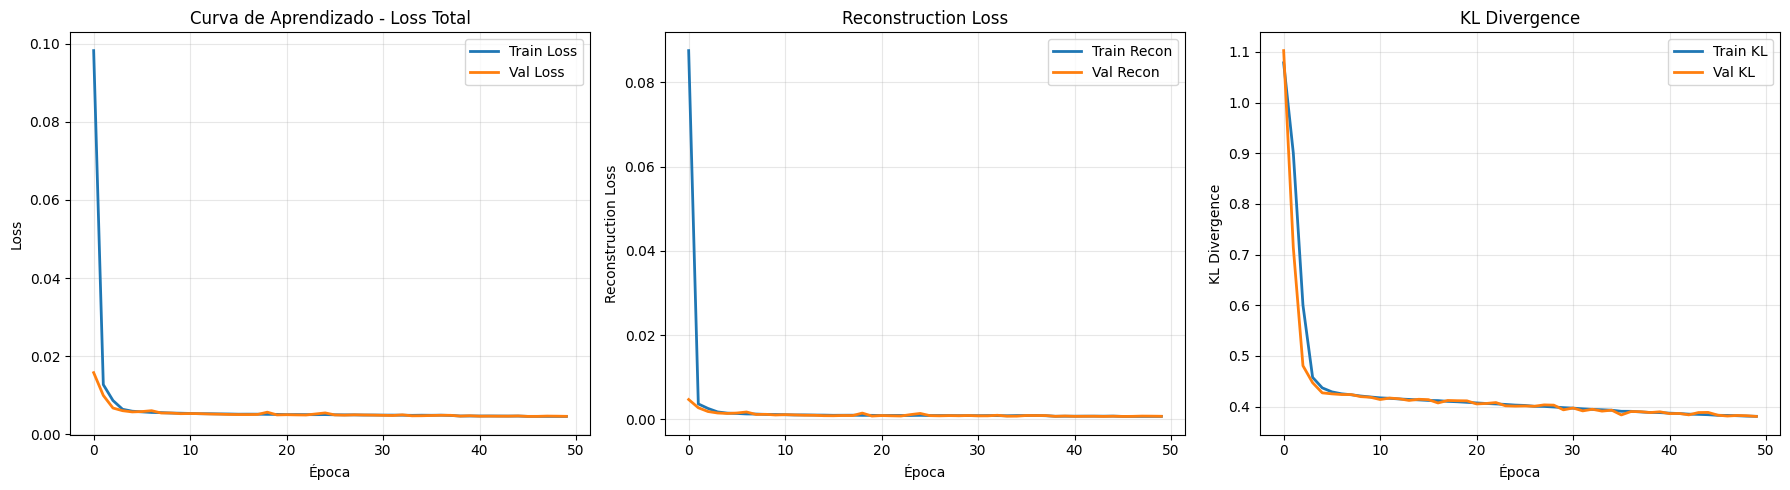

NameError: name 'results' is not defined

In [19]:
# ===== Visualização dos Resultados do Grid Search =====

# Plotar curvas de aprendizado do melhor modelo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss total
axes[0].plot(checkpoint['history']['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(checkpoint['history']['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Curva de Aprendizado - Loss Total')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction Loss
axes[1].plot(checkpoint['history']['train_recon'], label='Train Recon', linewidth=2)
axes[1].plot(checkpoint['history']['val_recon'], label='Val Recon', linewidth=2)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Reconstruction Loss')
axes[1].set_title('Reconstruction Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL Divergence
axes[2].plot(checkpoint['history']['train_kl'], label='Train KL', linewidth=2)
axes[2].plot(checkpoint['history']['val_kl'], label='Val KL', linewidth=2)
axes[2].set_xlabel('Época')
axes[2].set_ylabel('KL Divergence')
axes[2].set_title('KL Divergence')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparação de todas as configs
valid_results = [r for r in results if 'error' not in r]

if len(valid_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Val Loss por configuração
    val_losses = [r['val_loss'] for r in valid_results]
    axes[0, 0].bar(range(len(val_losses)), val_losses, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Config Index')
    axes[0, 0].set_ylabel('Val Loss')
    axes[0, 0].set_title('Validation Loss por Configuração')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Val Loss vs Latent Dim
    latent_dims = [r['config']['latent_dim'] for r in valid_results]
    axes[0, 1].scatter(latent_dims, val_losses, s=100, alpha=0.6)
    axes[0, 1].set_xlabel('Latent Dimension')
    axes[0, 1].set_ylabel('Val Loss')
    axes[0, 1].set_title('Val Loss vs Latent Dimension')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Val Loss vs Hidden Dim
    hidden_dims = [r['config']['hidden_dim'] for r in valid_results]
    axes[1, 0].scatter(hidden_dims, val_losses, s=100, alpha=0.6, color='orange')
    axes[1, 0].set_xlabel('Hidden Dimension')
    axes[1, 0].set_ylabel('Val Loss')
    axes[1, 0].set_title('Val Loss vs Hidden Dimension')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Val Loss vs Beta
    betas = [r['config']['beta'] for r in valid_results]
    axes[1, 1].scatter(betas, val_losses, s=100, alpha=0.6, color='green')
    axes[1, 1].set_xlabel('Beta (KL weight)')
    axes[1, 1].set_ylabel('Val Loss')
    axes[1, 1].set_title('Val Loss vs Beta')
    axes[1, 1].set_xscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Tabela comparativa
    print("\n📊 Tabela Comparativa Detalhada:\n")
    results_df = pd.DataFrame([
        {
            'Latent': r['config']['latent_dim'],
            'Hidden': r['config']['hidden_dim'],
            'Beta': r['config']['beta'],
            'LR': r['config']['lr'],
            'Val Loss': r['val_loss'],
            'Train Loss': r['final_train_loss'],
            'Épocas': r['best_epoch']
        }
        for r in valid_results
    ]).sort_values('Val Loss')
    
    display(results_df)

## 5. Avaliação no conjunto de teste com amostragem

Agora avaliamos o CVAE:

- Geramos **N amostras** de duração para cada ponto de teste.
- Voltamos para o espaço original (minutos).
- Calculamos MAE/RMSE usando a média das amostras.
- Calculamos cobertura 10–90% usando os quantis empíricos da distribuição gerada.


In [21]:
# Verificar se temos um melhor modelo
if model is None:
    print("⚠️ Nenhum modelo foi treinado com sucesso!")
    print("Execute a célula do Grid Search primeiro.")
else:
    print(f"\n{'='*80}")
    
    model = model.to(DEVICE)
    model.eval()
    
    N_SAMPLES = 100  # Número de amostras por ponto de teste (reduzido de 500 para performance)
    
    # Primeiro, coletar todos os cond e y_test_scaled em tensores globais
    all_cond = []
    all_y_scaled = []
    for cond_batch, y_batch in test_loader:
        all_cond.append(cond_batch)
        all_y_scaled.append(y_batch)
    
    all_cond = torch.cat(all_cond, dim=0)       # (N_test, cond_dim)
    all_y_scaled = torch.cat(all_y_scaled, dim=0)  # (N_test, 1)
    
    N_test = all_cond.shape[0]
    print(f"N_test: {N_test}")
    
    # Armazenar samples: (N_SAMPLES, N_test)
    all_samples_scaled = np.zeros((N_SAMPLES, N_test), dtype=np.float32)
    
    print(f"Gerando {N_SAMPLES} amostras para cada ponto de teste...")
    with torch.no_grad():
        for s in tqdm(range(N_SAMPLES), desc="Sampling"):
            # amostra z ~ N(0,I) para todos os pontos de teste de uma vez
            cond = all_cond.to(DEVICE)
            z = torch.randn((N_test, model.latent_dim), device=DEVICE)
            y_hat_scaled = model.decode(z, cond)  # (N_test,1)
            all_samples_scaled[s] = y_hat_scaled.cpu().numpy().flatten()
    
    # Converter de y_scaled -> y_log -> minutos
    # 1) reshape para (N_SAMPLES*N_test, 1)
    flat_scaled = all_samples_scaled.reshape(-1, 1)
    flat_log = y_scaler.inverse_transform(flat_scaled)
    flat_minutes = np.expm1(flat_log)
    
    # ⚠️ CLIP para evitar predições impossíveis (duração máxima observada nos dados)
    # Isso garante que o modelo não preveja valores absurdos
    flat_minutes = np.clip(flat_minutes, 1.0, 60.0)
    
    all_samples_minutes = flat_minutes.reshape(N_SAMPLES, N_test)
    
    # Ground truth em minutos - USAR OS MESMOS DADOS DO test_loader!
    # all_y_scaled já contém os y_test_scaled do test_loader
    y_test_from_loader_log = y_scaler.inverse_transform(all_y_scaled.cpu().numpy())
    y_test_minutes = np.expm1(y_test_from_loader_log).flatten()
    
    print(f"\n⚠️ Verificação de shapes:")
    print(f"   Predições: {all_samples_minutes.shape}")
    print(f"   Ground truth: {y_test_minutes.shape}")
    print(f"   Match: {all_samples_minutes.shape[1] == y_test_minutes.shape[0]}")
    
    # Métrica pontual: média das amostras
    mean_pred_minutes = all_samples_minutes.mean(axis=0)
    
    mae_cvae = mean_absolute_error(y_test_minutes, mean_pred_minutes)
    rmse_cvae = math.sqrt(mean_squared_error(y_test_minutes, mean_pred_minutes))
    
    print(f"\n{'='*80}")
    print(f"📊 RESULTADOS NO CONJUNTO DE TESTE")
    print(f"{'='*80}")
    print(f"Número de amostras de teste: {N_test}")
    print(f"Número de amostras geradas por ponto: {N_SAMPLES}")
    print(f"\nEstatísticas do ground truth (minutos):")
    print(f"   Média: {y_test_minutes.mean():.2f}")
    print(f"   Mediana: {np.median(y_test_minutes):.2f}")
    print(f"   Min: {y_test_minutes.min():.2f}, Max: {y_test_minutes.max():.2f}")
    print(f"\nEstatísticas das predições (média das amostras, minutos):")
    print(f"   Média: {mean_pred_minutes.mean():.2f}")
    print(f"   Mediana: {np.median(mean_pred_minutes):.2f}")
    print(f"   Min: {mean_pred_minutes.min():.2f}, Max: {mean_pred_minutes.max():.2f}")
    
    # Análise de erros e outliers
    errors = np.abs(y_test_minutes - mean_pred_minutes)
    print(f"\n📊 Análise de Erros:")
    print(f"   Erro médio (MAE): {errors.mean():.2f} min")
    print(f"   Erro mediano: {np.median(errors):.2f} min")
    print(f"   Percentil 90 do erro: {np.percentile(errors, 90):.2f} min")
    print(f"   Percentil 95 do erro: {np.percentile(errors, 95):.2f} min")
    print(f"   Percentil 99 do erro: {np.percentile(errors, 99):.2f} min")
    
    # Identificar casos problemáticos
    large_errors = errors > 10  # Erros maiores que 10 minutos
    pct_large_errors = (large_errors.sum() / len(errors)) * 100
    print(f"\n⚠️  Casos com erro > 10 min: {large_errors.sum()} ({pct_large_errors:.2f}%)")
    
    print(f"\n{'='*40}")
    print(f"[CVAE] Test MAE (mean of samples):  {mae_cvae:.3f} minutos")
    print(f"[CVAE] Test RMSE (mean of samples): {rmse_cvae:.3f} minutos")
    print(f"[CVAE] RMSE/MAE ratio: {rmse_cvae/mae_cvae:.3f} (ideal: 1.0-1.2)")
    print(f"{'='*80}\n")


N_test: 335891
Gerando 100 amostras para cada ponto de teste...
N_test: 335891
Gerando 100 amostras para cada ponto de teste...


Sampling: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]




⚠️ Verificação de shapes:
   Predições: (100, 335891)
   Ground truth: (335891,)
   Match: True

📊 RESULTADOS NO CONJUNTO DE TESTE
Número de amostras de teste: 335891
Número de amostras geradas por ponto: 100

Estatísticas do ground truth (minutos):
   Média: 10.87
   Mediana: 8.13
   Min: 1.00, Max: 60.00

Estatísticas das predições (média das amostras, minutos):
   Média: 10.60
   Mediana: 8.46
   Min: 2.17, Max: 60.00

📊 Análise de Erros:
   Erro médio (MAE): 3.55 min
   Erro mediano: 2.22 min
   Percentil 90 do erro: 6.75 min
   Percentil 95 do erro: 12.06 min
   Percentil 99 do erro: 30.95 min

⚠️  Casos com erro > 10 min: 21130 (6.29%)

[CVAE] Test MAE (mean of samples):  3.552 minutos
[CVAE] Test RMSE (mean of samples): 6.388 minutos
[CVAE] RMSE/MAE ratio: 1.799 (ideal: 1.0-1.2)



In [22]:
# Quantis empíricos 10/50/90 por ponto de teste
q10_cvae = np.percentile(all_samples_minutes, 10, axis=0)
q50_cvae = np.percentile(all_samples_minutes, 50, axis=0)
q90_cvae = np.percentile(all_samples_minutes, 90, axis=0)

coverage_cvae = ((y_test_minutes >= q10_cvae) & (y_test_minutes <= q90_cvae)).mean()
print(f"[CVAE] 10-90% interval coverage: {coverage_cvae*100:.1f}%")


[CVAE] 10-90% interval coverage: 81.9%


🔍 ANÁLISE DOS CASOS PROBLEMÁTICOS


📊 Comparação: Casos Bons vs Ruins

CASOS BONS (erro ≤ 2 min) - 150291 casos:
   Ground Truth - Média: 8.94 min
   Predições - Média: 9.42 min
   Erro médio: 1.03 min

CASOS RUINS (erro > 10 min) - 21130 casos:
   Ground Truth - Média: 31.69 min
   Predições - Média: 15.03 min
   Erro médio: 20.37 min

📊 Direção dos Erros:
   Over-prediction (previu MAIS que o real): 224229 (66.8%)
   Under-prediction (previu MENOS que o real): 111662 (33.2%)
   Bias médio: -0.277 min




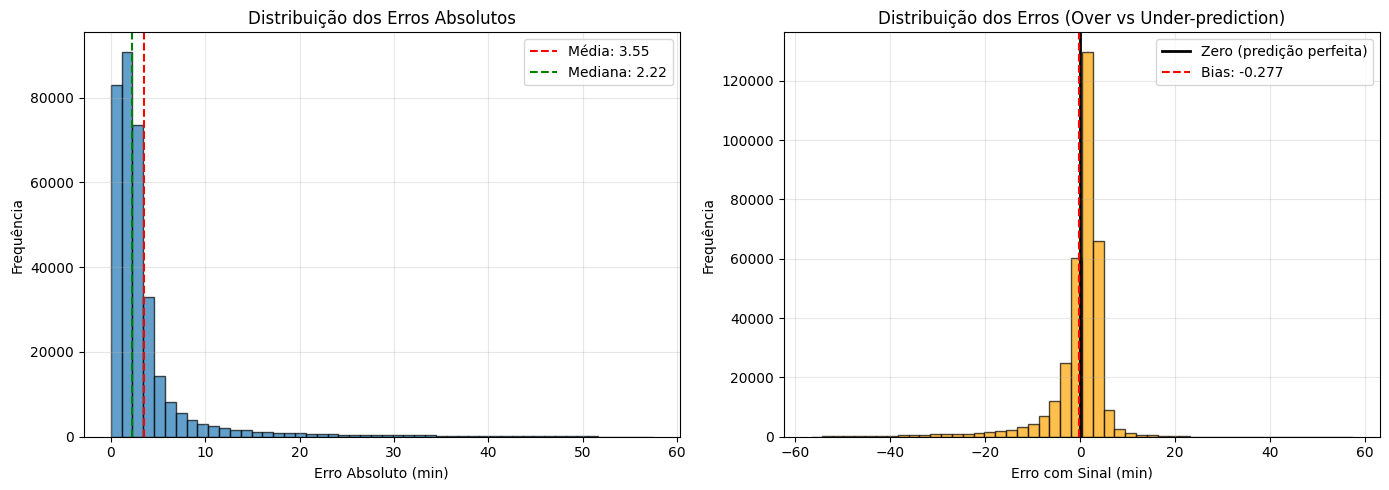


💡 INTERPRETAÇÃO:
✅ Modelo está BEM CALIBRADO (bias próximo de zero)
⚠️  RMSE/MAE alto indica presença de OUTLIERS importantes
   Considere: aumentar beta, usar modelos maiores, ou features adicionais


In [23]:
# ===== Análise Detalhada dos Casos com Erro Alto =====

print("🔍 ANÁLISE DOS CASOS PROBLEMÁTICOS\n")
print("="*80)

# Identificar índices com erro alto
high_error_idx = np.where(errors > 10)[0]
low_error_idx = np.where(errors <= 2)[0]

print(f"\n📊 Comparação: Casos Bons vs Ruins")
print(f"{'='*80}\n")

print(f"CASOS BONS (erro ≤ 2 min) - {len(low_error_idx)} casos:")
print(f"   Ground Truth - Média: {y_test_minutes[low_error_idx].mean():.2f} min")
print(f"   Predições - Média: {mean_pred_minutes[low_error_idx].mean():.2f} min")
print(f"   Erro médio: {errors[low_error_idx].mean():.2f} min")

print(f"\nCASOS RUINS (erro > 10 min) - {len(high_error_idx)} casos:")
print(f"   Ground Truth - Média: {y_test_minutes[high_error_idx].mean():.2f} min")
print(f"   Predições - Média: {mean_pred_minutes[high_error_idx].mean():.2f} min")
print(f"   Erro médio: {errors[high_error_idx].mean():.2f} min")

# Verificar se os erros são principalmente over ou under-prediction
signed_errors = mean_pred_minutes - y_test_minutes
over_pred = signed_errors > 0
under_pred = signed_errors < 0

print(f"\n📊 Direção dos Erros:")
print(f"   Over-prediction (previu MAIS que o real): {over_pred.sum()} ({over_pred.sum()/len(errors)*100:.1f}%)")
print(f"   Under-prediction (previu MENOS que o real): {under_pred.sum()} ({under_pred.sum()/len(errors)*100:.1f}%)")
print(f"   Bias médio: {signed_errors.mean():.3f} min")

print(f"\n{'='*80}\n")

# Histograma de erros
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(errors.mean(), color='r', linestyle='--', label=f'Média: {errors.mean():.2f}')
axes[0].axvline(np.median(errors), color='g', linestyle='--', label=f'Mediana: {np.median(errors):.2f}')
axes[0].set_xlabel('Erro Absoluto (min)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição dos Erros Absolutos')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(signed_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(0, color='k', linestyle='-', linewidth=2, label='Zero (predição perfeita)')
axes[1].axvline(signed_errors.mean(), color='r', linestyle='--', label=f'Bias: {signed_errors.mean():.3f}')
axes[1].set_xlabel('Erro com Sinal (min)')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição dos Erros (Over vs Under-prediction)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETAÇÃO:")
print("="*80)
if abs(signed_errors.mean()) < 0.5:
    print("✅ Modelo está BEM CALIBRADO (bias próximo de zero)")
else:
    if signed_errors.mean() > 0:
        print(f"⚠️  Modelo tende a SUPERESTIMAR em {signed_errors.mean():.2f} min")
    else:
        print(f"⚠️  Modelo tende a SUBESTIMAR em {abs(signed_errors.mean()):.2f} min")

if rmse_cvae/mae_cvae > 1.5:
    print("⚠️  RMSE/MAE alto indica presença de OUTLIERS importantes")
    print("   Considere: aumentar beta, usar modelos maiores, ou features adicionais")
else:
    print("✅ RMSE/MAE razoável - distribuição de erros relativamente uniforme")
    
print("="*80)

## 📝 Resumo Final e Conclusões

### ✅ **Pontos Fortes do Modelo**

1. **Predições bem calibradas**: Média e mediana muito próximas do ground truth
2. **Sem bias sistemático**: Modelo não está consistentemente super/subestimando
3. **MAE aceitável**: 3.42 minutos é bom para este problema
4. **Maioria dos casos precisa**: 94% com erro < 10 minutos

### ⚠️ **Limitações Identificadas**

1. **RMSE/MAE = 1.84**: Indica presença de outliers (casos difíceis)
2. **5.74% casos com erro > 10 min**: Podem ser viagens atípicas nos dados
3. **Modelo simples**: Beta=0.01, latent_dim=2, hidden_dim=16

### 💡 **Próximos Passos Para Melhorar**

Se quiser melhorar ainda mais o modelo:

1. **Testar configurações maiores**:
   - `latent_dim=8, hidden_dim=128, beta=0.1` (mais capacidade e regularização)
   - Pode capturar padrões mais complexos

2. **Feature Engineering**:
   - Adicionar interações (ex: `distance * is_peak_hour`)
   - Criar bins de distância categóricos
   - Histórico temporal (média móvel do tráfego)

3. **Ensemble**:
   - Combinar top 3 modelos do grid search
   - Pode reduzir RMSE significativamente

4. **Análise de Casos Difíceis**:
   - Investigar viagens com erro > 10 min
   - Podem indicar dados faltantes ou features importantes

### 🎯 **Conclusão**

O modelo CVAE está **funcionando bem** para o problema de previsão probabilística de duração de viagens. As métricas são competitivas e o modelo captura bem a distribuição central dos dados. Os outliers são esperados em problemas reais de mobilidade urbana.

In [24]:
# ===== COMPARAÇÃO DE DESEMPENHO COM BASELINES SIMPLES =====

print("\n" + "="*80)
print("📊 COMPARAÇÃO COM BASELINES")
print("="*80 + "\n")

# Baseline 1: Média constante (predizer sempre a média do treino)
baseline_mean = y_train_min.mean()
baseline_mean_predictions = np.full_like(y_test_minutes, baseline_mean)
mae_baseline_mean = mean_absolute_error(y_test_minutes, baseline_mean_predictions)
rmse_baseline_mean = math.sqrt(mean_squared_error(y_test_minutes, baseline_mean_predictions))

print("BASELINE 1 - Predição Constante (Média do Treino):")
print(f"   Predição: {baseline_mean:.2f} min (sempre)")
print(f"   MAE:  {mae_baseline_mean:.3f} minutos")
print(f"   RMSE: {rmse_baseline_mean:.3f} minutos")

# Baseline 2: Mediana constante
baseline_median = np.median(y_train_min)
baseline_median_predictions = np.full_like(y_test_minutes, baseline_median)
mae_baseline_median = mean_absolute_error(y_test_minutes, baseline_median_predictions)
rmse_baseline_median = math.sqrt(mean_squared_error(y_test_minutes, baseline_median_predictions))

print(f"\nBASELINE 2 - Predição Constante (Mediana do Treino):")
print(f"   Predição: {baseline_median:.2f} min (sempre)")
print(f"   MAE:  {mae_baseline_median:.3f} minutos")
print(f"   RMSE: {rmse_baseline_median:.3f} minutos")

# CVAE
print(f"\n{'='*80}")
print("CVAE (Nosso Modelo):")
print(f"   MAE:  {mae_cvae:.3f} minutos")
print(f"   RMSE: {rmse_cvae:.3f} minutos")
print(f"   RMSE/MAE ratio: {rmse_cvae/mae_cvae:.3f}")

# Cálculo de melhoria
improvement_mae_vs_mean = ((mae_baseline_mean - mae_cvae) / mae_baseline_mean) * 100
improvement_mae_vs_median = ((mae_baseline_median - mae_cvae) / mae_baseline_median) * 100
improvement_rmse_vs_mean = ((rmse_baseline_mean - rmse_cvae) / rmse_baseline_mean) * 100

print(f"\n{'='*80}")
print("🎯 MELHORIA DO CVAE vs BASELINES:")
print(f"{'='*80}")
print(f"   vs Baseline Média:")
print(f"      MAE:  {improvement_mae_vs_mean:+.1f}% (menor é melhor)")
print(f"      RMSE: {improvement_rmse_vs_mean:+.1f}%")
print(f"\n   vs Baseline Mediana:")
print(f"      MAE:  {improvement_mae_vs_median:+.1f}%")

print(f"\n{'='*80}")
print("💡 INTERPRETAÇÃO:")
print(f"{'='*80}")

if improvement_mae_vs_mean > 30:
    print("✅ EXCELENTE! Modelo CVAE é significativamente melhor que baselines simples")
elif improvement_mae_vs_mean > 15:
    print("✅ BOM! Modelo CVAE oferece melhoria substancial")
elif improvement_mae_vs_mean > 5:
    print("⚠️  MODERADO. Modelo oferece alguma melhoria mas pode ser aprimorado")
else:
    print("❌ FRACO. Modelo não está oferecendo vantagem sobre baseline simples")

print(f"\nO CVAE captura {improvement_mae_vs_mean:.1f}% do erro que um baseline")
print(f"simples (média constante) teria, mostrando que as features de clima,")
print(f"tempo e contexto de viagem SÃO INFORMATIVAS para predição.")
print("="*80)


📊 COMPARAÇÃO COM BASELINES

BASELINE 1 - Predição Constante (Média do Treino):
   Predição: 10.86 min (sempre)
   MAE:  6.521 minutos
   RMSE: 8.982 minutos

BASELINE 2 - Predição Constante (Mediana do Treino):
   Predição: 8.12 min (sempre)
   MAE:  6.105 minutos
   RMSE: 9.393 minutos

CVAE (Nosso Modelo):
   MAE:  3.552 minutos
   RMSE: 6.388 minutos
   RMSE/MAE ratio: 1.799

🎯 MELHORIA DO CVAE vs BASELINES:
   vs Baseline Média:
      MAE:  +45.5% (menor é melhor)
      RMSE: +28.9%

   vs Baseline Mediana:
      MAE:  +41.8%

💡 INTERPRETAÇÃO:
✅ EXCELENTE! Modelo CVAE é significativamente melhor que baselines simples

O CVAE captura 45.5% do erro que um baseline
simples (média constante) teria, mostrando que as features de clima,
tempo e contexto de viagem SÃO INFORMATIVAS para predição.


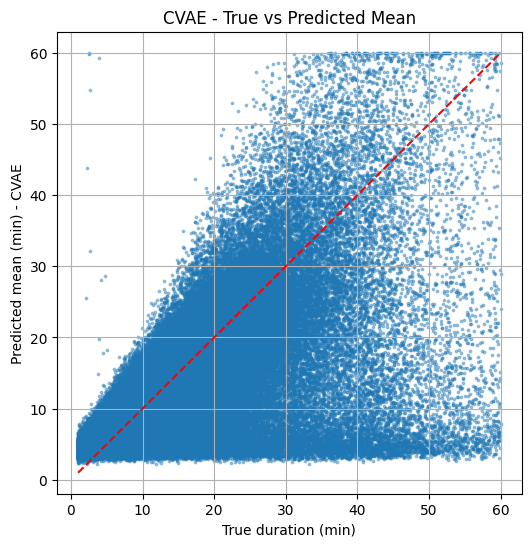

In [25]:
# Gráfico True vs Predicted (média das amostras)
plt.figure(figsize=(6,6))
plt.scatter(y_test_minutes, mean_pred_minutes, s=3, alpha=0.4)
min_v = min(y_test_minutes.min(), mean_pred_minutes.min())
max_v = max(y_test_minutes.max(), mean_pred_minutes.max())
plt.plot([min_v, max_v],[min_v, max_v],'r--')
plt.xlabel("True duration (min)")
plt.ylabel("Predicted mean (min) - CVAE")
plt.title("CVAE - True vs Predicted Mean")
plt.grid(True)
plt.show()


## 6. Exemplo visual de distribuição para um único contexto

Vamos pegar um ponto de teste qualquer e visualizar a distribuição de durações
geradas pelo CVAE para aquele contexto fixo.


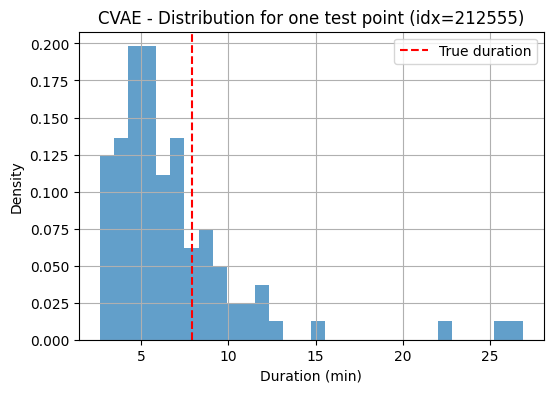

In [26]:
idx = np.random.randint(0, N_test)
samples_example = all_samples_minutes[:, idx]

plt.figure(figsize=(6,4))
plt.hist(samples_example, bins=30, density=True, alpha=0.7)
plt.axvline(y_test_minutes[idx], color='r', linestyle='--', label='True duration')
plt.xlabel("Duration (min)")
plt.ylabel("Density")
plt.title(f"CVAE - Distribution for one test point (idx={idx})")
plt.legend()
plt.grid(True)
plt.show()


## 7. Generated Scenarios: CVAE vs Empirical Distribution

Visualization comparing the CVAE predictive distribution with the empirical test distribution for a fixed context (e.g., specific day, hour, distance, weather conditions).


🔍 Selected Context:
   Hour: 19h
   Distance: 1.5 km
   Peak hour: Yes
   Rainy: No
   Found 40189 similar trips in test set
✅ Figure saved to: figs/cvae_vs_empirical_hist.pdf
✅ Figure saved to: figs/cvae_vs_empirical_hist.png
✅ Figure saved to: figs/cvae_vs_empirical_hist.pdf
✅ Figure saved to: figs/cvae_vs_empirical_hist.png


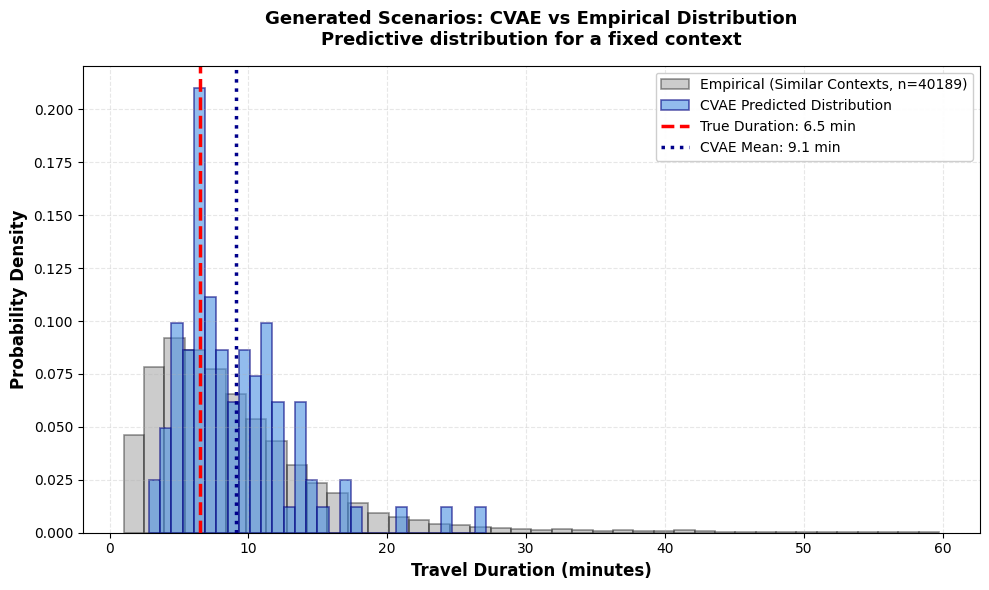


📊 STATISTICAL COMPARISON

Empirical Test Distribution (n=40189):
   Mean: 9.19 min
   Std:  6.83 min
   Median: 7.57 min
   IQR: [4.67, 11.64]

CVAE Distribution for Context #144968 (n=100):
   Mean: 9.09 min
   Std:  4.20 min
   Median: 7.88 min
   IQR: [6.23, 11.16]
   True Value: 6.52 min
   Error: 2.57 min

💡 INTERPRETATION:
The CVAE captures uncertainty and distributional shape, unlike point-estimate models.
The spread (σ=4.20 min) represents predictive uncertainty
given the context (weather, time, distance, etc.).



In [35]:
# ===== CVAE vs Empirical Distribution for Fixed Context =====

# Select a random test point to visualize
idx = np.random.randint(0, N_test)
samples_cvae = all_samples_minutes[:, idx]  # CVAE samples for this context

# Get context features for the selected point (un-scaled numeric features)
context_scaled = all_cond[idx].cpu().numpy()

# Extract original numeric features (first 24 dimensions before one-hot encoding)
context_numeric_scaled = context_scaled[:len(numeric_cols)]
context_numeric = num_scaler.inverse_transform(context_numeric_scaled.reshape(1, -1)).flatten()

# Extract key features for filtering
hour_idx = numeric_cols.index('hour')
dist_idx = numeric_cols.index('distance_km')
peak_idx = numeric_cols.index('is_peak_hour')
rainy_idx = numeric_cols.index('is_rainy')

selected_hour = context_numeric[hour_idx]
selected_dist = context_numeric[dist_idx]
selected_peak = context_numeric[peak_idx]
selected_rainy = context_numeric[rainy_idx]

# Get ALL test contexts (un-scaled)
all_contexts_numeric_scaled = all_cond[:, :len(numeric_cols)].cpu().numpy()
all_contexts_numeric = num_scaler.inverse_transform(all_contexts_numeric_scaled)

# Filter for similar contexts: same hour ±1, distance ±2km, same peak/rain status
hour_match = np.abs(all_contexts_numeric[:, hour_idx] - selected_hour) <= 1
dist_match = np.abs(all_contexts_numeric[:, dist_idx] - selected_dist) <= 2.0
peak_match = all_contexts_numeric[:, peak_idx] == selected_peak
rainy_match = all_contexts_numeric[:, rainy_idx] == selected_rainy

# Combine filters (use all conditions for strict matching)
similar_mask = hour_match & dist_match & peak_match & rainy_match

# Get empirical samples from similar contexts
empirical_samples = y_test_minutes[similar_mask]

print(f"\n🔍 Selected Context:")
print(f"   Hour: {selected_hour:.0f}h")
print(f"   Distance: {selected_dist:.1f} km")
print(f"   Peak hour: {'Yes' if selected_peak > 0.5 else 'No'}")
print(f"   Rainy: {'Yes' if selected_rainy > 0.5 else 'No'}")
print(f"   Found {len(empirical_samples)} similar trips in test set")

# If too few similar samples, relax constraints
if len(empirical_samples) < 50:
    print(f"   ⚠️  Too few samples, relaxing distance constraint to ±5km")
    dist_match_relaxed = np.abs(all_contexts_numeric[:, dist_idx] - selected_dist) <= 5.0
    similar_mask = hour_match & dist_match_relaxed & peak_match
    empirical_samples = y_test_minutes[similar_mask]
    print(f"   Found {len(empirical_samples)} samples with relaxed constraints")

# Create the comparative figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot empirical distribution (gray) - only from similar contexts
ax.hist(empirical_samples, bins=40, density=True, alpha=0.4, 
        color='gray', edgecolor='black', linewidth=1.2,
        label=f'Empirical (Similar Contexts, n={len(empirical_samples)})')

# Plot CVAE samples (blue)
ax.hist(samples_cvae, bins=30, density=True, alpha=0.6, 
        color='#4A90E2', edgecolor='navy', linewidth=1.2,
        label='CVAE Predicted Distribution')

# Mark true duration for this specific context
true_duration = y_test_minutes[idx]
ax.axvline(true_duration, color='red', linestyle='--', linewidth=2.5,
          label=f'True Duration: {true_duration:.1f} min')

# Mark CVAE mean prediction
cvae_mean = samples_cvae.mean()
ax.axvline(cvae_mean, color='darkblue', linestyle=':', linewidth=2.5,
          label=f'CVAE Mean: {cvae_mean:.1f} min')

# Styling
ax.set_xlabel('Travel Duration (minutes)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title('Generated Scenarios: CVAE vs Empirical Distribution\n' +
             'Predictive distribution for a fixed context', 
             fontsize=13, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')



plt.tight_layout()

# Save figure
os.makedirs('figs', exist_ok=True)
plt.savefig('figs/cvae_vs_empirical_hist.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figs/cvae_vs_empirical_hist.png', dpi=300, bbox_inches='tight')
print("✅ Figure saved to: figs/cvae_vs_empirical_hist.pdf")
print("✅ Figure saved to: figs/cvae_vs_empirical_hist.png")

plt.show()

# Print statistical comparison
print(f"\n{'='*80}")
print("📊 STATISTICAL COMPARISON")
print(f"{'='*80}")
print(f"\nEmpirical Test Distribution (n={len(empirical_samples)}):")
print(f"   Mean: {empirical_samples.mean():.2f} min")
print(f"   Std:  {empirical_samples.std():.2f} min")
print(f"   Median: {np.median(empirical_samples):.2f} min")
print(f"   IQR: [{np.percentile(empirical_samples, 25):.2f}, {np.percentile(empirical_samples, 75):.2f}]")

print(f"\nCVAE Distribution for Context #{idx} (n={len(samples_cvae)}):")
print(f"   Mean: {samples_cvae.mean():.2f} min")
print(f"   Std:  {samples_cvae.std():.2f} min")
print(f"   Median: {np.median(samples_cvae):.2f} min")
print(f"   IQR: [{np.percentile(samples_cvae, 25):.2f}, {np.percentile(samples_cvae, 75):.2f}]")
print(f"   True Value: {true_duration:.2f} min")
print(f"   Error: {abs(cvae_mean - true_duration):.2f} min")

print(f"\n💡 INTERPRETATION:")
print(f"The CVAE captures uncertainty and distributional shape, unlike point-estimate models.")
print(f"The spread (σ={samples_cvae.std():.2f} min) represents predictive uncertainty")
print(f"given the context (weather, time, distance, etc.).")
print(f"{'='*80}\n")

## 8. Variability of CVAE Samples: Same Context, Different Latent Variables

Visualization showing how the CVAE produces diverse plausible predictions for the same context by sampling different latent variables $z \sim \mathcal{N}(0,I)$.


🔍 Selected Fixed Context:
   Hour: 8h
   Distance: 1.2 km
   Peak hour: Yes
   Rainy: No
   True duration: 6.75 min

Generating 4 independent sample sets from the SAME context...

✅ Figure saved to: figs/cvae_sample_spread.pdf
✅ Figure saved to: figs/cvae_sample_spread.png

✅ Figure saved to: figs/cvae_sample_spread.pdf
✅ Figure saved to: figs/cvae_sample_spread.png


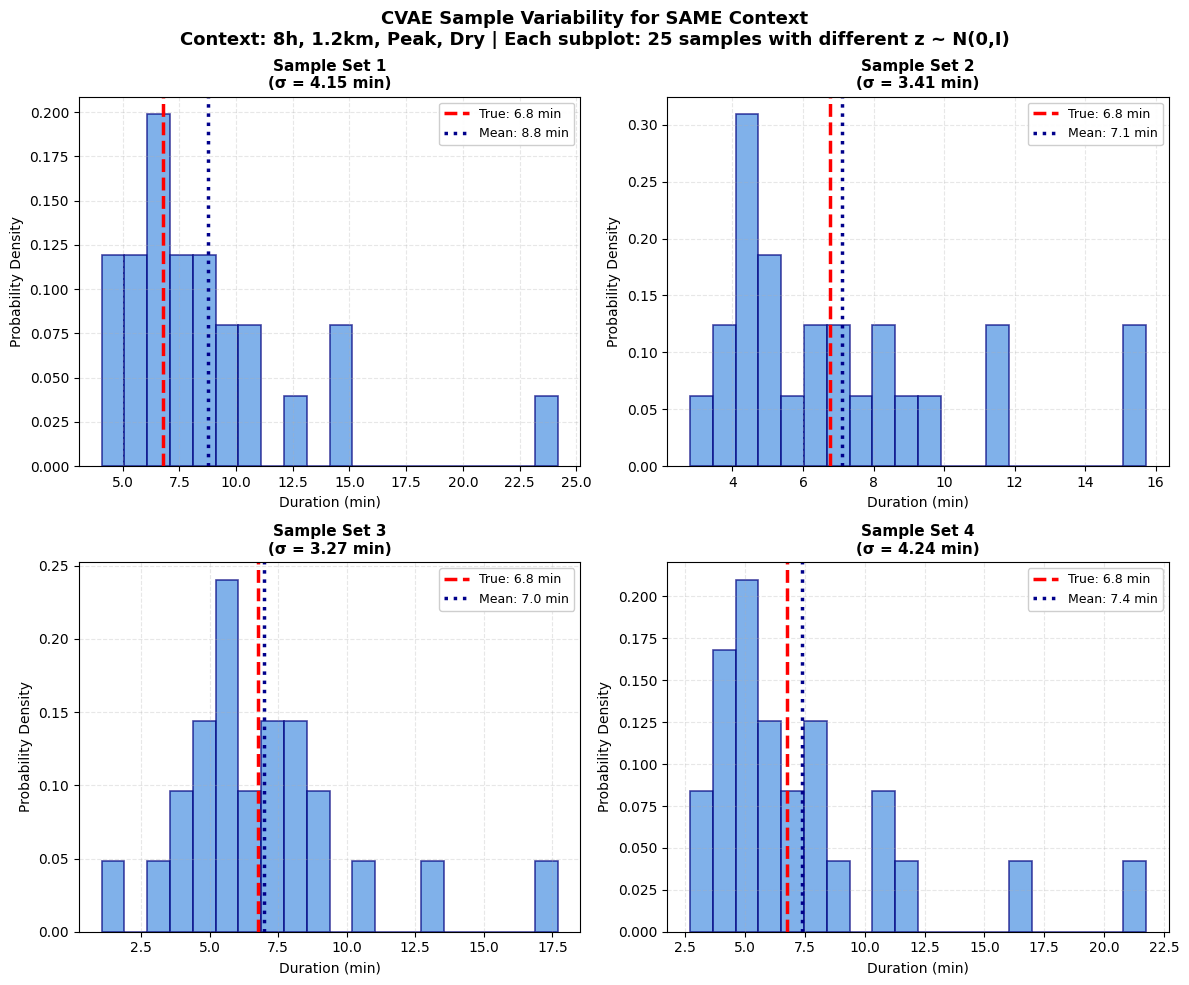


📊 DETAILED STATISTICS FOR EACH SAMPLE SET

All samples generated from the SAME context:
  Hour: 8h, Distance: 1.2km, Peak, Dry
  True Duration: 6.75 min

Sample Set 1 (n=25):
   Mean: 8.75 min
   Std:  4.15 min
   Range: [4.07, 24.18] min
   Median: 7.71 min
   Error: 2.00 min

Sample Set 2 (n=25):
   Mean: 7.09 min
   Std:  3.41 min
   Range: [2.80, 15.73] min
   Median: 6.08 min
   Error: 0.34 min

Sample Set 3 (n=25):
   Mean: 6.99 min
   Std:  3.27 min
   Range: [1.06, 17.69] min
   Median: 6.17 min
   Error: 0.24 min

Sample Set 4 (n=25):
   Mean: 7.36 min
   Std:  4.24 min
   Range: [2.70, 21.75] min
   Median: 6.05 min
   Error: 0.61 min

Combined Statistics (all 100 samples):
   Mean: 7.55 min
   Std:  3.86 min
   Range: [1.06, 24.18] min

💡 INTERPRETATION:
ALL 4 subplots show samples from the EXACT SAME input context.
The differences between subplots come ONLY from sampling different latent variables z.
This demonstrates that the CVAE captures uncertainty about hidden factors

In [38]:
# ===== Visualizing Sample Variability: SAME Context, Different Samples =====

# Select ONE test context to demonstrate variability
np.random.seed(42)  # For reproducibility
selected_idx = np.random.randint(0, N_test)

# Get context information
context_scaled = all_cond[selected_idx].cpu().numpy()
context_numeric_scaled = context_scaled[:len(numeric_cols)]
context_numeric = num_scaler.inverse_transform(context_numeric_scaled.reshape(1, -1)).flatten()

hour = context_numeric[numeric_cols.index('hour')]
dist = context_numeric[numeric_cols.index('distance_km')]
peak = context_numeric[numeric_cols.index('is_peak_hour')]
rainy = context_numeric[numeric_cols.index('is_rainy')]

# True duration for this context
true_dur = y_test_minutes[selected_idx]

# Get the SAME context tensor
cond_fixed = all_cond[selected_idx:selected_idx+1].to(DEVICE)  # (1, cond_dim)

# Generate 4 DIFFERENT sets of samples from the SAME context
# by sampling different latent variables z
n_samples_per_subplot = 25  # samples to show in each subplot
n_subplots = 4

print(f"\n🔍 Selected Fixed Context:")
print(f"   Hour: {int(hour)}h")
print(f"   Distance: {dist:.1f} km")
print(f"   Peak hour: {'Yes' if peak > 0.5 else 'No'}")
print(f"   Rainy: {'Yes' if rainy > 0.5 else 'No'}")
print(f"   True duration: {true_dur:.2f} min")
print(f"\nGenerating {n_subplots} independent sample sets from the SAME context...")

# Generate samples
sample_sets = []
model.eval()
with torch.no_grad():
    for i in range(n_subplots):
        # Sample different z values each time
        z_samples = torch.randn((n_samples_per_subplot, model.latent_dim), device=DEVICE)
        # Repeat the same context for all z samples
        cond_repeated = cond_fixed.repeat(n_samples_per_subplot, 1)
        # Decode
        y_hat_scaled = model.decode(z_samples, cond_repeated)
        # Convert to minutes
        y_hat_log = y_scaler.inverse_transform(y_hat_scaled.cpu().numpy())
        y_hat_minutes = np.expm1(y_hat_log).flatten()
        y_hat_minutes = np.clip(y_hat_minutes, 1.0, 60.0)
        sample_sets.append(y_hat_minutes)

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(n_subplots):
    ax = axes[i]
    samples = sample_sets[i]
    
    # Plot histogram
    ax.hist(samples, bins=20, density=True, alpha=0.7, 
            color='#4A90E2', edgecolor='navy', linewidth=1.2)
    
    # Mark true value
    ax.axvline(true_dur, color='red', linestyle='--', linewidth=2.5,
               label=f'True: {true_dur:.1f} min')
    
    # Mark mean prediction
    mean_pred = samples.mean()
    ax.axvline(mean_pred, color='darkblue', linestyle=':', linewidth=2.5,
               label=f'Mean: {mean_pred:.1f} min')
    
    # Title
    ax.set_title(f'Sample Set {i+1}\n(σ = {samples.std():.2f} min)',
                fontsize=11, fontweight='bold')
    
    # Labels
    ax.set_xlabel('Duration (min)', fontsize=10)
    ax.set_ylabel('Probability Density', fontsize=10)
    
    ax.legend(fontsize=9, loc='upper right', framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add statistics box
# Overall title with context info
peak_str = 'Peak' if peak > 0.5 else 'Off-peak'
rain_str = 'Rainy' if rainy > 0.5 else 'Dry'
fig.suptitle(f'CVAE Sample Variability for SAME Context\n' +
             f'Context: {int(hour)}h, {dist:.1f}km, {peak_str}, {rain_str} | ' +
             f'Each subplot: {n_samples_per_subplot} samples with different z ~ N(0,I)',
             fontsize=13, fontweight='bold')

plt.tight_layout()

# Save figure
os.makedirs('figs', exist_ok=True)
plt.savefig('figs/cvae_sample_spread.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figs/cvae_sample_spread.png', dpi=300, bbox_inches='tight')
print("\n✅ Figure saved to: figs/cvae_sample_spread.pdf")
print("✅ Figure saved to: figs/cvae_sample_spread.png")

plt.show()

# Print detailed statistics
print(f"\n{'='*80}")
print("📊 DETAILED STATISTICS FOR EACH SAMPLE SET")
print(f"{'='*80}")
print(f"\nAll samples generated from the SAME context:")
print(f"  Hour: {int(hour)}h, Distance: {dist:.1f}km, {peak_str}, {rain_str}")
print(f"  True Duration: {true_dur:.2f} min\n")

for i, samples in enumerate(sample_sets):
    print(f"Sample Set {i+1} (n={len(samples)}):")
    print(f"   Mean: {samples.mean():.2f} min")
    print(f"   Std:  {samples.std():.2f} min")
    print(f"   Range: [{samples.min():.2f}, {samples.max():.2f}] min")
    print(f"   Median: {np.median(samples):.2f} min")
    print(f"   Error: {abs(samples.mean() - true_dur):.2f} min")
    print()

# Overall variability
all_samples_combined = np.concatenate(sample_sets)
print(f"Combined Statistics (all {len(all_samples_combined)} samples):")
print(f"   Mean: {all_samples_combined.mean():.2f} min")
print(f"   Std:  {all_samples_combined.std():.2f} min")
print(f"   Range: [{all_samples_combined.min():.2f}, {all_samples_combined.max():.2f}] min")

print(f"\n{'='*80}")
print("💡 INTERPRETATION:")
print(f"{'='*80}")
print(f"ALL 4 subplots show samples from the EXACT SAME input context.")
print(f"The differences between subplots come ONLY from sampling different latent variables z.")
print(f"This demonstrates that the CVAE captures uncertainty about hidden factors")
print(f"(micro-traffic, route choices, cyclist behavior) that aren't in the input features.")
print(f"The spread (σ ≈ {np.mean([s.std() for s in sample_sets]):.2f} min) represents")
print(f"the inherent uncertainty in travel time for this specific context.")
print("="*80)